In [5]:
import keras
import numpy as np
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop
%matplotlib inline
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'keras'

In [4]:
from jena.dataset import jena_dataset

headers, data = jena_dataset()
print(headers)
temp = data[:, 1]
plt.plot(temp)
plt.show()
plt.plot(temp[:1440])
plt.show()

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


NameError: name 'plt' is not defined

In [6]:
mean = data[:200000].mean(axis=0)
data -= mean
std = data[:200000].std(axis=0)
data /= std


def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(data) - 300001 - lookback) // batch_size

In [9]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [13]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
  1/500 [..............................] - ETA: 1:12 - loss: 1.3061

  9/500 [..............................] - ETA: 11s - loss: 4.8282 

 12/500 [..............................] - ETA: 10s - loss: 4.6339

 15/500 [..............................] - ETA: 10s - loss: 4.3816

 17/500 [>.............................] - ETA: 10s - loss: 4.2582

 20/500 [>.............................] - ETA: 10s - loss: 4.1074

 23/500 [>.............................] - ETA: 10s - loss: 3.9470

 25/500 [>.............................] - ETA: 10s - loss: 3.8992

 29/500 [>.............................] - ETA: 10s - loss: 3.7327

 32/500 [>.............................] - ETA: 9s - loss: 3.6563 

 35/500 [=>............................] - ETA: 9s - loss: 3.5553

 38/500 [=>............................] - ETA: 9s - loss: 3.5245

 41/500 [=>............................] - ETA: 9s - loss: 3.4723

 44/500 [=>............................] - ETA: 9s - loss: 3.4475

 47/500 [=>............................] - ETA: 9s - loss: 3.4279

 50/500 [==>...........................] - ETA: 9s - loss: 3.3836

 53/500 [==>...........................] - ETA: 9s - loss: 3.3312

 56/500 [==>...........................] - ETA: 8s - loss: 3.2935

 59/500 [==>...........................] - ETA: 8s - loss: 3.2271

 62/500 [==>...........................] - ETA: 8s - loss: 3.2262

 65/500 [==>...........................] - ETA: 8s - loss: 3.1917

 69/500 [===>..........................] - ETA: 8s - loss: 3.1619

 72/500 [===>..........................] - ETA: 8s - loss: 3.1329

 75/500 [===>..........................] - ETA: 8s - loss: 3.1142

 78/500 [===>..........................] - ETA: 8s - loss: 3.1005

 81/500 [===>..........................] - ETA: 8s - loss: 3.0858

 84/500 [====>.........................] - ETA: 7s - loss: 3.0659

 88/500 [====>.........................] - ETA: 7s - loss: 3.0390

 91/500 [====>.........................] - ETA: 7s - loss: 3.0210

 95/500 [====>.........................] - ETA: 7s - loss: 3.0002

 99/500 [====>.........................] - ETA: 7s - loss: 2.9817

102/500 [=====>........................] - ETA: 7s - loss: 2.9579

105/500 [=====>........................] - ETA: 7s - loss: 2.9478

109/500 [=====>........................] - ETA: 7s - loss: 2.9359

112/500 [=====>........................] - ETA: 7s - loss: 2.9221

116/500 [=====>........................] - ETA: 6s - loss: 2.9097

119/500 [======>.......................] - ETA: 6s - loss: 2.8957

122/500 [======>.......................] - ETA: 6s - loss: 2.8827

125/500 [======>.......................] - ETA: 6s - loss: 2.8760

128/500 [======>.......................] - ETA: 6s - loss: 2.8627

132/500 [======>.......................] - ETA: 6s - loss: 2.8321

135/500 [=======>......................] - ETA: 6s - loss: 2.8288

139/500 [=======>......................] - ETA: 6s - loss: 2.8196

143/500 [=======>......................] - ETA: 6s - loss: 2.8046

147/500 [=======>......................] - ETA: 6s - loss: 2.7904

150/500 [========>.....................] - ETA: 6s - loss: 2.7782

154/500 [========>.....................] - ETA: 6s - loss: 2.7686

158/500 [========>.....................] - ETA: 6s - loss: 2.7624

161/500 [========>.....................] - ETA: 5s - loss: 2.7505

165/500 [========>.....................] - ETA: 5s - loss: 2.7337

169/500 [=========>....................] - ETA: 5s - loss: 2.7175

173/500 [=========>....................] - ETA: 5s - loss: 2.7079

176/500 [=========>....................] - ETA: 5s - loss: 2.6998

180/500 [=========>....................] - ETA: 5s - loss: 2.6942

184/500 [==========>...................] - ETA: 5s - loss: 2.6770

188/500 [==========>...................] - ETA: 5s - loss: 2.6629

192/500 [==========>...................] - ETA: 5s - loss: 2.6461

196/500 [==========>...................] - ETA: 5s - loss: 2.6326

200/500 [===========>..................] - ETA: 5s - loss: 2.6219

204/500 [===========>..................] - ETA: 5s - loss: 2.6115

208/500 [===========>..................] - ETA: 4s - loss: 2.6003

212/500 [===========>..................] - ETA: 4s - loss: 2.5858

216/500 [===========>..................] - ETA: 4s - loss: 2.5722

220/500 [============>.................] - ETA: 4s - loss: 2.5621

224/500 [============>.................] - ETA: 4s - loss: 2.5484

227/500 [============>.................] - ETA: 4s - loss: 2.5406

231/500 [============>.................] - ETA: 4s - loss: 2.5307

235/500 [=============>................] - ETA: 4s - loss: 2.5189

239/500 [=============>................] - ETA: 4s - loss: 2.5103

243/500 [=============>................] - ETA: 4s - loss: 2.5021

247/500 [=============>................] - ETA: 4s - loss: 2.4890

251/500 [==============>...............] - ETA: 4s - loss: 2.4765

255/500 [==============>...............] - ETA: 4s - loss: 2.4634

259/500 [==============>...............] - ETA: 4s - loss: 2.4541

262/500 [==============>...............] - ETA: 3s - loss: 2.4471

265/500 [==============>...............] - ETA: 3s - loss: 2.4388

269/500 [===============>..............] - ETA: 3s - loss: 2.4300

272/500 [===============>..............] - ETA: 3s - loss: 2.4203

275/500 [===============>..............] - ETA: 3s - loss: 2.4138

279/500 [===============>..............] - ETA: 3s - loss: 2.4045

282/500 [===============>..............] - ETA: 3s - loss: 2.3997

286/500 [================>.............] - ETA: 3s - loss: 2.3893

290/500 [================>.............] - ETA: 3s - loss: 2.3787

293/500 [================>.............] - ETA: 3s - loss: 2.3717

297/500 [================>.............] - ETA: 3s - loss: 2.3599

300/500 [=================>............] - ETA: 3s - loss: 2.3513

303/500 [=================>............] - ETA: 3s - loss: 2.3461

306/500 [=================>............] - ETA: 3s - loss: 2.3392

309/500 [=================>............] - ETA: 3s - loss: 2.3330

312/500 [=================>............] - ETA: 3s - loss: 2.3271

315/500 [=================>............] - ETA: 3s - loss: 2.3176

318/500 [==================>...........] - ETA: 3s - loss: 2.3081

321/500 [==================>...........] - ETA: 3s - loss: 2.3011

324/500 [==================>...........] - ETA: 2s - loss: 2.2942

327/500 [==================>...........] - ETA: 2s - loss: 2.2885

330/500 [==================>...........] - ETA: 2s - loss: 2.2823

333/500 [==================>...........] - ETA: 2s - loss: 2.2760

337/500 [===================>..........] - ETA: 2s - loss: 2.2694

341/500 [===================>..........] - ETA: 2s - loss: 2.2601

345/500 [===================>..........] - ETA: 2s - loss: 2.2507

349/500 [===================>..........] - ETA: 2s - loss: 2.2434

352/500 [====================>.........] - ETA: 2s - loss: 2.2367

356/500 [====================>.........] - ETA: 2s - loss: 2.2287

360/500 [====================>.........] - ETA: 2s - loss: 2.2203

364/500 [====================>.........] - ETA: 2s - loss: 2.2102

368/500 [=====================>........] - ETA: 2s - loss: 2.2020

372/500 [=====================>........] - ETA: 2s - loss: 2.1939

376/500 [=====================>........] - ETA: 2s - loss: 2.1866

379/500 [=====================>........] - ETA: 2s - loss: 2.1805

383/500 [=====================>........] - ETA: 1s - loss: 2.1733

387/500 [======================>.......] - ETA: 1s - loss: 2.1636

391/500 [======================>.......] - ETA: 1s - loss: 2.1560

394/500 [======================>.......] - ETA: 1s - loss: 2.1518

398/500 [======================>.......] - ETA: 1s - loss: 2.1448

402/500 [=======================>......] - ETA: 1s - loss: 2.1371

406/500 [=======================>......] - ETA: 1s - loss: 2.1290

410/500 [=======================>......] - ETA: 1s - loss: 2.1213

413/500 [=======================>......] - ETA: 1s - loss: 2.1159

417/500 [========================>.....] - ETA: 1s - loss: 2.1078

421/500 [========================>.....] - ETA: 1s - loss: 2.1009

424/500 [========================>.....] - ETA: 1s - loss: 2.0948

428/500 [========================>.....] - ETA: 1s - loss: 2.0881

431/500 [========================>.....] - ETA: 1s - loss: 2.0826

435/500 [=========================>....] - ETA: 1s - loss: 2.0756

438/500 [=========================>....] - ETA: 1s - loss: 2.0703

442/500 [=========================>....] - ETA: 0s - loss: 2.0633

445/500 [=========================>....] - ETA: 0s - loss: 2.0576

449/500 [=========================>....] - ETA: 0s - loss: 2.0504

453/500 [==========================>...] - ETA: 0s - loss: 2.0426

457/500 [==========================>...] - ETA: 0s - loss: 2.0338

461/500 [==========================>...] - ETA: 0s - loss: 2.0272

464/500 [==========================>...] - ETA: 0s - loss: 2.0223

468/500 [===========================>..] - ETA: 0s - loss: 2.0161

471/500 [===========================>..] - ETA: 0s - loss: 2.0099

475/500 [===========================>..] - ETA: 0s - loss: 2.0038

478/500 [===========================>..] - ETA: 0s - loss: 1.9985

482/500 [===========================>..] - ETA: 0s - loss: 1.9898

486/500 [============================>.] - ETA: 0s - loss: 1.9836

489/500 [============================>.] - ETA: 0s - loss: 1.9781

493/500 [============================>.] - ETA: 0s - loss: 1.9710

497/500 [============================>.] - ETA: 0s - loss: 1.9644

500/500 [==============================] - 17s 35ms/step - loss: 1.9591 - val_loss: 1.1483


Epoch 2/20
  1/500 [..............................] - ETA: 3s - loss: 1.1900

  9/500 [..............................] - ETA: 3s - loss: 1.0861

 14/500 [..............................] - ETA: 3s - loss: 1.1049

 18/500 [>.............................] - ETA: 4s - loss: 1.0791

 22/500 [>.............................] - ETA: 5s - loss: 1.0721

 26/500 [>.............................] - ETA: 5s - loss: 1.0569

 29/500 [>.............................] - ETA: 5s - loss: 1.0664

 33/500 [>.............................] - ETA: 5s - loss: 1.0678

 37/500 [=>............................] - ETA: 5s - loss: 1.0641

 40/500 [=>............................] - ETA: 5s - loss: 1.0704

 44/500 [=>............................] - ETA: 5s - loss: 1.0676

 48/500 [=>............................] - ETA: 5s - loss: 1.0615

 51/500 [==>...........................] - ETA: 5s - loss: 1.0582

 54/500 [==>...........................] - ETA: 6s - loss: 1.0669

 58/500 [==>...........................] - ETA: 5s - loss: 1.0593

 61/500 [==>...........................] - ETA: 6s - loss: 1.0552

 64/500 [==>...........................] - ETA: 6s - loss: 1.0521

 68/500 [===>..........................] - ETA: 6s - loss: 1.0488

 72/500 [===>..........................] - ETA: 5s - loss: 1.0456

 76/500 [===>..........................] - ETA: 5s - loss: 1.0415

 79/500 [===>..........................] - ETA: 5s - loss: 1.0357

 83/500 [===>..........................] - ETA: 5s - loss: 1.0345

 87/500 [====>.........................] - ETA: 5s - loss: 1.0321

 91/500 [====>.........................] - ETA: 5s - loss: 1.0300

 95/500 [====>.........................] - ETA: 5s - loss: 1.0187

 99/500 [====>.........................] - ETA: 5s - loss: 1.0149

103/500 [=====>........................] - ETA: 5s - loss: 1.0156

107/500 [=====>........................] - ETA: 5s - loss: 1.0100

111/500 [=====>........................] - ETA: 5s - loss: 1.0067

114/500 [=====>........................] - ETA: 5s - loss: 1.0040

118/500 [======>.......................] - ETA: 5s - loss: 0.9976

122/500 [======>.......................] - ETA: 5s - loss: 0.9883

126/500 [======>.......................] - ETA: 5s - loss: 0.9845

130/500 [======>.......................] - ETA: 5s - loss: 0.9813

134/500 [=======>......................] - ETA: 5s - loss: 0.9769

138/500 [=======>......................] - ETA: 5s - loss: 0.9750

142/500 [=======>......................] - ETA: 5s - loss: 0.9702

146/500 [=======>......................] - ETA: 5s - loss: 0.9672

150/500 [========>.....................] - ETA: 5s - loss: 0.9645

154/500 [========>.....................] - ETA: 4s - loss: 0.9610

157/500 [========>.....................] - ETA: 4s - loss: 0.9561

161/500 [========>.....................] - ETA: 4s - loss: 0.9509

165/500 [========>.....................] - ETA: 4s - loss: 0.9471

168/500 [=========>....................] - ETA: 4s - loss: 0.9435

172/500 [=========>....................] - ETA: 4s - loss: 0.9386

175/500 [=========>....................] - ETA: 4s - loss: 0.9374

178/500 [=========>....................] - ETA: 4s - loss: 0.9327

181/500 [=========>....................] - ETA: 4s - loss: 0.9312

185/500 [==========>...................] - ETA: 4s - loss: 0.9290

189/500 [==========>...................] - ETA: 4s - loss: 0.9241

192/500 [==========>...................] - ETA: 4s - loss: 0.9188

195/500 [==========>...................] - ETA: 4s - loss: 0.9158

199/500 [==========>...................] - ETA: 4s - loss: 0.9140

203/500 [===========>..................] - ETA: 4s - loss: 0.9095

206/500 [===========>..................] - ETA: 4s - loss: 0.9058

210/500 [===========>..................] - ETA: 4s - loss: 0.9024

214/500 [===========>..................] - ETA: 4s - loss: 0.8972

218/500 [============>.................] - ETA: 4s - loss: 0.8930

222/500 [============>.................] - ETA: 4s - loss: 0.8893

226/500 [============>.................] - ETA: 4s - loss: 0.8875

230/500 [============>.................] - ETA: 4s - loss: 0.8837

234/500 [=============>................] - ETA: 3s - loss: 0.8806

238/500 [=============>................] - ETA: 3s - loss: 0.8767

242/500 [=============>................] - ETA: 3s - loss: 0.8732

245/500 [=============>................] - ETA: 3s - loss: 0.8693

249/500 [=============>................] - ETA: 3s - loss: 0.8651

252/500 [==============>...............] - ETA: 3s - loss: 0.8622

256/500 [==============>...............] - ETA: 3s - loss: 0.8609

259/500 [==============>...............] - ETA: 3s - loss: 0.8578

263/500 [==============>...............] - ETA: 3s - loss: 0.8542

267/500 [===============>..............] - ETA: 3s - loss: 0.8499

271/500 [===============>..............] - ETA: 3s - loss: 0.8462

274/500 [===============>..............] - ETA: 3s - loss: 0.8435

279/500 [===============>..............] - ETA: 3s - loss: 0.8399

282/500 [===============>..............] - ETA: 3s - loss: 0.8369

286/500 [================>.............] - ETA: 3s - loss: 0.8333

289/500 [================>.............] - ETA: 3s - loss: 0.8308

293/500 [================>.............] - ETA: 3s - loss: 0.8273

296/500 [================>.............] - ETA: 3s - loss: 0.8252

300/500 [=================>............] - ETA: 2s - loss: 0.8208

304/500 [=================>............] - ETA: 2s - loss: 0.8182

308/500 [=================>............] - ETA: 2s - loss: 0.8151

312/500 [=================>............] - ETA: 2s - loss: 0.8113

316/500 [=================>............] - ETA: 2s - loss: 0.8075

320/500 [==================>...........] - ETA: 2s - loss: 0.8049

323/500 [==================>...........] - ETA: 2s - loss: 0.8029

327/500 [==================>...........] - ETA: 2s - loss: 0.7999

330/500 [==================>...........] - ETA: 2s - loss: 0.7975

334/500 [===================>..........] - ETA: 2s - loss: 0.7937

337/500 [===================>..........] - ETA: 2s - loss: 0.7914

341/500 [===================>..........] - ETA: 2s - loss: 0.7881

345/500 [===================>..........] - ETA: 2s - loss: 0.7842

349/500 [===================>..........] - ETA: 2s - loss: 0.7813

353/500 [====================>.........] - ETA: 2s - loss: 0.7786

357/500 [====================>.........] - ETA: 2s - loss: 0.7751

360/500 [====================>.........] - ETA: 2s - loss: 0.7718

364/500 [====================>.........] - ETA: 2s - loss: 0.7697

368/500 [=====================>........] - ETA: 1s - loss: 0.7666

372/500 [=====================>........] - ETA: 1s - loss: 0.7644

376/500 [=====================>........] - ETA: 1s - loss: 0.7619

380/500 [=====================>........] - ETA: 1s - loss: 0.7585

384/500 [======================>.......] - ETA: 1s - loss: 0.7548

388/500 [======================>.......] - ETA: 1s - loss: 0.7521

392/500 [======================>.......] - ETA: 1s - loss: 0.7496

396/500 [======================>.......] - ETA: 1s - loss: 0.7465

400/500 [=======================>......] - ETA: 1s - loss: 0.7427

404/500 [=======================>......] - ETA: 1s - loss: 0.7404

408/500 [=======================>......] - ETA: 1s - loss: 0.7372

412/500 [=======================>......] - ETA: 1s - loss: 0.7352

416/500 [=======================>......] - ETA: 1s - loss: 0.7320

419/500 [========================>.....] - ETA: 1s - loss: 0.7299

422/500 [========================>.....] - ETA: 1s - loss: 0.7280

426/500 [========================>.....] - ETA: 1s - loss: 0.7249

430/500 [========================>.....] - ETA: 1s - loss: 0.7225

434/500 [=========================>....] - ETA: 0s - loss: 0.7201

438/500 [=========================>....] - ETA: 0s - loss: 0.7179

441/500 [=========================>....] - ETA: 0s - loss: 0.7155

445/500 [=========================>....] - ETA: 0s - loss: 0.7126

449/500 [=========================>....] - ETA: 0s - loss: 0.7106

453/500 [==========================>...] - ETA: 0s - loss: 0.7081

457/500 [==========================>...] - ETA: 0s - loss: 0.7048

461/500 [==========================>...] - ETA: 0s - loss: 0.7015

466/500 [==========================>...] - ETA: 0s - loss: 0.6981

470/500 [===========================>..] - ETA: 0s - loss: 0.6960

473/500 [===========================>..] - ETA: 0s - loss: 0.6943

478/500 [===========================>..] - ETA: 0s - loss: 0.6919

482/500 [===========================>..] - ETA: 0s - loss: 0.6899

486/500 [============================>.] - ETA: 0s - loss: 0.6872

489/500 [============================>.] - ETA: 0s - loss: 0.6853

493/500 [============================>.] - ETA: 0s - loss: 0.6826

497/500 [============================>.] - ETA: 0s - loss: 0.6802

500/500 [==============================] - 16s 33ms/step - loss: 0.6788 - val_loss: 0.4049


Epoch 3/20
  1/500 [..............................] - ETA: 2s - loss: 0.3925

 10/500 [..............................] - ETA: 2s - loss: 0.4069

 15/500 [..............................] - ETA: 3s - loss: 0.3795

 19/500 [>.............................] - ETA: 4s - loss: 0.3984

 24/500 [>.............................] - ETA: 4s - loss: 0.3882

 28/500 [>.............................] - ETA: 5s - loss: 0.3881

 33/500 [>.............................] - ETA: 5s - loss: 0.3824

 37/500 [=>............................] - ETA: 5s - loss: 0.3793

 41/500 [=>............................] - ETA: 5s - loss: 0.3804

 45/500 [=>............................] - ETA: 5s - loss: 0.3756

 48/500 [=>............................] - ETA: 5s - loss: 0.3804

 51/500 [==>...........................] - ETA: 5s - loss: 0.3813

 54/500 [==>...........................] - ETA: 5s - loss: 0.3834

 57/500 [==>...........................] - ETA: 5s - loss: 0.3803

 60/500 [==>...........................] - ETA: 6s - loss: 0.3766

 64/500 [==>...........................] - ETA: 5s - loss: 0.3776

 68/500 [===>..........................] - ETA: 5s - loss: 0.3780

 72/500 [===>..........................] - ETA: 5s - loss: 0.3764

 75/500 [===>..........................] - ETA: 5s - loss: 0.3742

 78/500 [===>..........................] - ETA: 6s - loss: 0.3743

 81/500 [===>..........................] - ETA: 6s - loss: 0.3741

 84/500 [====>.........................] - ETA: 6s - loss: 0.3718

 87/500 [====>.........................] - ETA: 6s - loss: 0.3689

 91/500 [====>.........................] - ETA: 5s - loss: 0.3685

 94/500 [====>.........................] - ETA: 6s - loss: 0.3706

 98/500 [====>.........................] - ETA: 5s - loss: 0.3695

101/500 [=====>........................] - ETA: 5s - loss: 0.3686

104/500 [=====>........................] - ETA: 5s - loss: 0.3689

108/500 [=====>........................] - ETA: 5s - loss: 0.3659

111/500 [=====>........................] - ETA: 5s - loss: 0.3643

115/500 [=====>........................] - ETA: 5s - loss: 0.3652

119/500 [======>.......................] - ETA: 5s - loss: 0.3666

123/500 [======>.......................] - ETA: 5s - loss: 0.3662

127/500 [======>.......................] - ETA: 5s - loss: 0.3643

131/500 [======>.......................] - ETA: 5s - loss: 0.3653

135/500 [=======>......................] - ETA: 5s - loss: 0.3650

139/500 [=======>......................] - ETA: 5s - loss: 0.3636

143/500 [=======>......................] - ETA: 5s - loss: 0.3616

146/500 [=======>......................] - ETA: 5s - loss: 0.3605

150/500 [========>.....................] - ETA: 5s - loss: 0.3606

154/500 [========>.....................] - ETA: 5s - loss: 0.3606

157/500 [========>.....................] - ETA: 5s - loss: 0.3601

161/500 [========>.....................] - ETA: 5s - loss: 0.3591

164/500 [========>.....................] - ETA: 5s - loss: 0.3580

168/500 [=========>....................] - ETA: 5s - loss: 0.3567

172/500 [=========>....................] - ETA: 4s - loss: 0.3574

176/500 [=========>....................] - ETA: 4s - loss: 0.3563

179/500 [=========>....................] - ETA: 4s - loss: 0.3552

183/500 [=========>....................] - ETA: 4s - loss: 0.3539

187/500 [==========>...................] - ETA: 4s - loss: 0.3540

190/500 [==========>...................] - ETA: 4s - loss: 0.3535

194/500 [==========>...................] - ETA: 4s - loss: 0.3530

198/500 [==========>...................] - ETA: 4s - loss: 0.3526

202/500 [===========>..................] - ETA: 4s - loss: 0.3532

205/500 [===========>..................] - ETA: 4s - loss: 0.3526

209/500 [===========>..................] - ETA: 4s - loss: 0.3513

213/500 [===========>..................] - ETA: 4s - loss: 0.3510

217/500 [============>.................] - ETA: 4s - loss: 0.3498

221/500 [============>.................] - ETA: 4s - loss: 0.3507

225/500 [============>.................] - ETA: 4s - loss: 0.3499

229/500 [============>.................] - ETA: 4s - loss: 0.3490

233/500 [============>.................] - ETA: 4s - loss: 0.3479

237/500 [=============>................] - ETA: 3s - loss: 0.3472

240/500 [=============>................] - ETA: 3s - loss: 0.3466

244/500 [=============>................] - ETA: 3s - loss: 0.3469

248/500 [=============>................] - ETA: 3s - loss: 0.3464

251/500 [==============>...............] - ETA: 3s - loss: 0.3462

255/500 [==============>...............] - ETA: 3s - loss: 0.3454

260/500 [==============>...............] - ETA: 3s - loss: 0.3448

264/500 [==============>...............] - ETA: 3s - loss: 0.3443

268/500 [===============>..............] - ETA: 3s - loss: 0.3433

271/500 [===============>..............] - ETA: 3s - loss: 0.3432

275/500 [===============>..............] - ETA: 3s - loss: 0.3425

279/500 [===============>..............] - ETA: 3s - loss: 0.3417

282/500 [===============>..............] - ETA: 3s - loss: 0.3419

286/500 [================>.............] - ETA: 3s - loss: 0.3407

289/500 [================>.............] - ETA: 3s - loss: 0.3403

292/500 [================>.............] - ETA: 3s - loss: 0.3398

296/500 [================>.............] - ETA: 3s - loss: 0.3392

300/500 [=================>............] - ETA: 3s - loss: 0.3390

303/500 [=================>............] - ETA: 2s - loss: 0.3385

306/500 [=================>............] - ETA: 2s - loss: 0.3381

309/500 [=================>............] - ETA: 2s - loss: 0.3376

312/500 [=================>............] - ETA: 2s - loss: 0.3371

315/500 [=================>............] - ETA: 2s - loss: 0.3369

319/500 [==================>...........] - ETA: 2s - loss: 0.3369

322/500 [==================>...........] - ETA: 2s - loss: 0.3368

325/500 [==================>...........] - ETA: 2s - loss: 0.3369

329/500 [==================>...........] - ETA: 2s - loss: 0.3366

333/500 [==================>...........] - ETA: 2s - loss: 0.3359

337/500 [===================>..........] - ETA: 2s - loss: 0.3352

341/500 [===================>..........] - ETA: 2s - loss: 0.3351

345/500 [===================>..........] - ETA: 2s - loss: 0.3346

349/500 [===================>..........] - ETA: 2s - loss: 0.3339

352/500 [====================>.........] - ETA: 2s - loss: 0.3335

356/500 [====================>.........] - ETA: 2s - loss: 0.3334

360/500 [====================>.........] - ETA: 2s - loss: 0.3336

364/500 [====================>.........] - ETA: 2s - loss: 0.3328

368/500 [=====================>........] - ETA: 2s - loss: 0.3324

372/500 [=====================>........] - ETA: 1s - loss: 0.3319

376/500 [=====================>........] - ETA: 1s - loss: 0.3311

379/500 [=====================>........] - ETA: 1s - loss: 0.3308

384/500 [======================>.......] - ETA: 1s - loss: 0.3300

387/500 [======================>.......] - ETA: 1s - loss: 0.3296

391/500 [======================>.......] - ETA: 1s - loss: 0.3294

394/500 [======================>.......] - ETA: 1s - loss: 0.3291

398/500 [======================>.......] - ETA: 1s - loss: 0.3289

401/500 [=======================>......] - ETA: 1s - loss: 0.3286

405/500 [=======================>......] - ETA: 1s - loss: 0.3282

409/500 [=======================>......] - ETA: 1s - loss: 0.3277

412/500 [=======================>......] - ETA: 1s - loss: 0.3272

416/500 [=======================>......] - ETA: 1s - loss: 0.3270

420/500 [========================>.....] - ETA: 1s - loss: 0.3265

423/500 [========================>.....] - ETA: 1s - loss: 0.3262

427/500 [========================>.....] - ETA: 1s - loss: 0.3259

431/500 [========================>.....] - ETA: 1s - loss: 0.3253

435/500 [=========================>....] - ETA: 0s - loss: 0.3251

439/500 [=========================>....] - ETA: 0s - loss: 0.3248

443/500 [=========================>....] - ETA: 0s - loss: 0.3246

447/500 [=========================>....] - ETA: 0s - loss: 0.3240

450/500 [==========================>...] - ETA: 0s - loss: 0.3238

454/500 [==========================>...] - ETA: 0s - loss: 0.3237

458/500 [==========================>...] - ETA: 0s - loss: 0.3235

462/500 [==========================>...] - ETA: 0s - loss: 0.3230

466/500 [==========================>...] - ETA: 0s - loss: 0.3229

470/500 [===========================>..] - ETA: 0s - loss: 0.3226

474/500 [===========================>..] - ETA: 0s - loss: 0.3221

478/500 [===========================>..] - ETA: 0s - loss: 0.3216

481/500 [===========================>..] - ETA: 0s - loss: 0.3214

485/500 [============================>.] - ETA: 0s - loss: 0.3213

489/500 [============================>.] - ETA: 0s - loss: 0.3212

493/500 [============================>.] - ETA: 0s - loss: 0.3207

497/500 [============================>.] - ETA: 0s - loss: 0.3202

500/500 [==============================] - 16s 32ms/step - loss: 0.3203 - val_loss: 0.3230


Epoch 4/20
  1/500 [..............................] - ETA: 2s - loss: 0.2803

  9/500 [..............................] - ETA: 3s - loss: 0.2771

 14/500 [..............................] - ETA: 4s - loss: 0.2780

 19/500 [>.............................] - ETA: 4s - loss: 0.2770

 22/500 [>.............................] - ETA: 5s - loss: 0.2769

 26/500 [>.............................] - ETA: 5s - loss: 0.2737

 30/500 [>.............................] - ETA: 5s - loss: 0.2767

 33/500 [>.............................] - ETA: 5s - loss: 0.2795

 37/500 [=>............................] - ETA: 5s - loss: 0.2778

 41/500 [=>............................] - ETA: 5s - loss: 0.2768

 45/500 [=>............................] - ETA: 5s - loss: 0.2779

 49/500 [=>............................] - ETA: 5s - loss: 0.2792

 53/500 [==>...........................] - ETA: 5s - loss: 0.2787

 57/500 [==>...........................] - ETA: 5s - loss: 0.2776

 60/500 [==>...........................] - ETA: 5s - loss: 0.2777

 64/500 [==>...........................] - ETA: 5s - loss: 0.2778

 68/500 [===>..........................] - ETA: 5s - loss: 0.2771

 72/500 [===>..........................] - ETA: 5s - loss: 0.2771

 76/500 [===>..........................] - ETA: 5s - loss: 0.2787

 80/500 [===>..........................] - ETA: 5s - loss: 0.2784

 84/500 [====>.........................] - ETA: 5s - loss: 0.2781

 88/500 [====>.........................] - ETA: 5s - loss: 0.2786

 92/500 [====>.........................] - ETA: 5s - loss: 0.2788

 96/500 [====>.........................] - ETA: 5s - loss: 0.2793

 99/500 [====>.........................] - ETA: 5s - loss: 0.2794

104/500 [=====>........................] - ETA: 5s - loss: 0.2796

107/500 [=====>........................] - ETA: 5s - loss: 0.2795

112/500 [=====>........................] - ETA: 5s - loss: 0.2794

115/500 [=====>........................] - ETA: 5s - loss: 0.2793

119/500 [======>.......................] - ETA: 5s - loss: 0.2794

122/500 [======>.......................] - ETA: 5s - loss: 0.2793

125/500 [======>.......................] - ETA: 5s - loss: 0.2792

129/500 [======>.......................] - ETA: 5s - loss: 0.2797

133/500 [======>.......................] - ETA: 5s - loss: 0.2798

137/500 [=======>......................] - ETA: 5s - loss: 0.2798

141/500 [=======>......................] - ETA: 5s - loss: 0.2793

145/500 [=======>......................] - ETA: 5s - loss: 0.2802

149/500 [=======>......................] - ETA: 5s - loss: 0.2798

153/500 [========>.....................] - ETA: 4s - loss: 0.2794

157/500 [========>.....................] - ETA: 4s - loss: 0.2788

160/500 [========>.....................] - ETA: 4s - loss: 0.2788

164/500 [========>.....................] - ETA: 4s - loss: 0.2786

168/500 [=========>....................] - ETA: 4s - loss: 0.2785

172/500 [=========>....................] - ETA: 4s - loss: 0.2785

176/500 [=========>....................] - ETA: 4s - loss: 0.2785

181/500 [=========>....................] - ETA: 4s - loss: 0.2780

185/500 [==========>...................] - ETA: 4s - loss: 0.2777

189/500 [==========>...................] - ETA: 4s - loss: 0.2779

193/500 [==========>...................] - ETA: 4s - loss: 0.2780

198/500 [==========>...................] - ETA: 4s - loss: 0.2775

201/500 [===========>..................] - ETA: 4s - loss: 0.2775

205/500 [===========>..................] - ETA: 4s - loss: 0.2770

209/500 [===========>..................] - ETA: 4s - loss: 0.2767

213/500 [===========>..................] - ETA: 4s - loss: 0.2762

217/500 [============>.................] - ETA: 4s - loss: 0.2757

221/500 [============>.................] - ETA: 4s - loss: 0.2763

224/500 [============>.................] - ETA: 3s - loss: 0.2758

227/500 [============>.................] - ETA: 3s - loss: 0.2757

231/500 [============>.................] - ETA: 3s - loss: 0.2758

234/500 [=============>................] - ETA: 3s - loss: 0.2754

237/500 [=============>................] - ETA: 3s - loss: 0.2756

240/500 [=============>................] - ETA: 3s - loss: 0.2758

244/500 [=============>................] - ETA: 3s - loss: 0.2760

247/500 [=============>................] - ETA: 3s - loss: 0.2759

250/500 [==============>...............] - ETA: 3s - loss: 0.2756

253/500 [==============>...............] - ETA: 3s - loss: 0.2757

257/500 [==============>...............] - ETA: 3s - loss: 0.2755

260/500 [==============>...............] - ETA: 3s - loss: 0.2756

264/500 [==============>...............] - ETA: 3s - loss: 0.2756

267/500 [===============>..............] - ETA: 3s - loss: 0.2755

270/500 [===============>..............] - ETA: 3s - loss: 0.2753

274/500 [===============>..............] - ETA: 3s - loss: 0.2749

278/500 [===============>..............] - ETA: 3s - loss: 0.2746

282/500 [===============>..............] - ETA: 3s - loss: 0.2749

286/500 [================>.............] - ETA: 3s - loss: 0.2745

290/500 [================>.............] - ETA: 3s - loss: 0.2747

294/500 [================>.............] - ETA: 3s - loss: 0.2745

298/500 [================>.............] - ETA: 2s - loss: 0.2745

302/500 [=================>............] - ETA: 2s - loss: 0.2742

305/500 [=================>............] - ETA: 2s - loss: 0.2740

309/500 [=================>............] - ETA: 2s - loss: 0.2741

313/500 [=================>............] - ETA: 2s - loss: 0.2740

316/500 [=================>............] - ETA: 2s - loss: 0.2738

320/500 [==================>...........] - ETA: 2s - loss: 0.2735

323/500 [==================>...........] - ETA: 2s - loss: 0.2732

326/500 [==================>...........] - ETA: 2s - loss: 0.2731

330/500 [==================>...........] - ETA: 2s - loss: 0.2729

333/500 [==================>...........] - ETA: 2s - loss: 0.2727

337/500 [===================>..........] - ETA: 2s - loss: 0.2726

341/500 [===================>..........] - ETA: 2s - loss: 0.2724

344/500 [===================>..........] - ETA: 2s - loss: 0.2727

348/500 [===================>..........] - ETA: 2s - loss: 0.2728

352/500 [====================>.........] - ETA: 2s - loss: 0.2726

357/500 [====================>.........] - ETA: 2s - loss: 0.2725

360/500 [====================>.........] - ETA: 2s - loss: 0.2727

365/500 [====================>.........] - ETA: 2s - loss: 0.2727

369/500 [=====================>........] - ETA: 1s - loss: 0.2724

373/500 [=====================>........] - ETA: 1s - loss: 0.2723

377/500 [=====================>........] - ETA: 1s - loss: 0.2723

381/500 [=====================>........] - ETA: 1s - loss: 0.2725

385/500 [======================>.......] - ETA: 1s - loss: 0.2724

389/500 [======================>.......] - ETA: 1s - loss: 0.2721

393/500 [======================>.......] - ETA: 1s - loss: 0.2719

397/500 [======================>.......] - ETA: 1s - loss: 0.2719

401/500 [=======================>......] - ETA: 1s - loss: 0.2718

405/500 [=======================>......] - ETA: 1s - loss: 0.2718

409/500 [=======================>......] - ETA: 1s - loss: 0.2718

412/500 [=======================>......] - ETA: 1s - loss: 0.2717

416/500 [=======================>......] - ETA: 1s - loss: 0.2714

419/500 [========================>.....] - ETA: 1s - loss: 0.2712

423/500 [========================>.....] - ETA: 1s - loss: 0.2713

427/500 [========================>.....] - ETA: 1s - loss: 0.2712

431/500 [========================>.....] - ETA: 1s - loss: 0.2710

435/500 [=========================>....] - ETA: 0s - loss: 0.2707

438/500 [=========================>....] - ETA: 0s - loss: 0.2706

442/500 [=========================>....] - ETA: 0s - loss: 0.2704

445/500 [=========================>....] - ETA: 0s - loss: 0.2707

450/500 [==========================>...] - ETA: 0s - loss: 0.2706

454/500 [==========================>...] - ETA: 0s - loss: 0.2704

458/500 [==========================>...] - ETA: 0s - loss: 0.2705

462/500 [==========================>...] - ETA: 0s - loss: 0.2706

466/500 [==========================>...] - ETA: 0s - loss: 0.2706

469/500 [===========================>..] - ETA: 0s - loss: 0.2706

473/500 [===========================>..] - ETA: 0s - loss: 0.2704

477/500 [===========================>..] - ETA: 0s - loss: 0.2705

481/500 [===========================>..] - ETA: 0s - loss: 0.2705

485/500 [============================>.] - ETA: 0s - loss: 0.2705

489/500 [============================>.] - ETA: 0s - loss: 0.2704

494/500 [============================>.] - ETA: 0s - loss: 0.2703

498/500 [============================>.] - ETA: 0s - loss: 0.2702

500/500 [==============================] - 16s 32ms/step - loss: 0.2701 - val_loss: 0.3137


Epoch 5/20
  1/500 [..............................] - ETA: 2s - loss: 0.2829

  9/500 [..............................] - ETA: 3s - loss: 0.2647

 15/500 [..............................] - ETA: 3s - loss: 0.2674

 19/500 [>.............................] - ETA: 4s - loss: 0.2634

 23/500 [>.............................] - ETA: 4s - loss: 0.2614

 27/500 [>.............................] - ETA: 4s - loss: 0.2621

 30/500 [>.............................] - ETA: 5s - loss: 0.2607

 34/500 [=>............................] - ETA: 5s - loss: 0.2614

 38/500 [=>............................] - ETA: 5s - loss: 0.2613

 42/500 [=>............................] - ETA: 5s - loss: 0.2619

 46/500 [=>............................] - ETA: 5s - loss: 0.2630

 50/500 [==>...........................] - ETA: 5s - loss: 0.2623

 53/500 [==>...........................] - ETA: 5s - loss: 0.2637

 56/500 [==>...........................] - ETA: 5s - loss: 0.2633

 60/500 [==>...........................] - ETA: 5s - loss: 0.2619

 64/500 [==>...........................] - ETA: 5s - loss: 0.2651

 68/500 [===>..........................] - ETA: 5s - loss: 0.2646

 72/500 [===>..........................] - ETA: 5s - loss: 0.2631

 75/500 [===>..........................] - ETA: 5s - loss: 0.2634

 79/500 [===>..........................] - ETA: 5s - loss: 0.2624

 83/500 [===>..........................] - ETA: 5s - loss: 0.2629

 87/500 [====>.........................] - ETA: 5s - loss: 0.2618

 90/500 [====>.........................] - ETA: 5s - loss: 0.2619

 94/500 [====>.........................] - ETA: 5s - loss: 0.2617

 98/500 [====>.........................] - ETA: 5s - loss: 0.2623

101/500 [=====>........................] - ETA: 5s - loss: 0.2624

104/500 [=====>........................] - ETA: 5s - loss: 0.2620

108/500 [=====>........................] - ETA: 5s - loss: 0.2620

111/500 [=====>........................] - ETA: 5s - loss: 0.2623

115/500 [=====>........................] - ETA: 5s - loss: 0.2626

119/500 [======>.......................] - ETA: 5s - loss: 0.2616

122/500 [======>.......................] - ETA: 5s - loss: 0.2614

126/500 [======>.......................] - ETA: 5s - loss: 0.2627

130/500 [======>.......................] - ETA: 5s - loss: 0.2624

134/500 [=======>......................] - ETA: 5s - loss: 0.2625

137/500 [=======>......................] - ETA: 5s - loss: 0.2625

140/500 [=======>......................] - ETA: 5s - loss: 0.2625

144/500 [=======>......................] - ETA: 5s - loss: 0.2618

148/500 [=======>......................] - ETA: 5s - loss: 0.2617

152/500 [========>.....................] - ETA: 5s - loss: 0.2617

156/500 [========>.....................] - ETA: 5s - loss: 0.2622

159/500 [========>.....................] - ETA: 4s - loss: 0.2621

163/500 [========>.....................] - ETA: 4s - loss: 0.2627

166/500 [========>.....................] - ETA: 4s - loss: 0.2624

170/500 [=========>....................] - ETA: 4s - loss: 0.2626

173/500 [=========>....................] - ETA: 4s - loss: 0.2626

177/500 [=========>....................] - ETA: 4s - loss: 0.2622

181/500 [=========>....................] - ETA: 4s - loss: 0.2626

185/500 [==========>...................] - ETA: 4s - loss: 0.2631

189/500 [==========>...................] - ETA: 4s - loss: 0.2629

193/500 [==========>...................] - ETA: 4s - loss: 0.2626

197/500 [==========>...................] - ETA: 4s - loss: 0.2626

201/500 [===========>..................] - ETA: 4s - loss: 0.2629

205/500 [===========>..................] - ETA: 4s - loss: 0.2625

209/500 [===========>..................] - ETA: 4s - loss: 0.2620

212/500 [===========>..................] - ETA: 4s - loss: 0.2620

215/500 [===========>..................] - ETA: 4s - loss: 0.2617

219/500 [============>.................] - ETA: 4s - loss: 0.2618

223/500 [============>.................] - ETA: 4s - loss: 0.2618

227/500 [============>.................] - ETA: 3s - loss: 0.2617

230/500 [============>.................] - ETA: 3s - loss: 0.2617

234/500 [=============>................] - ETA: 3s - loss: 0.2617

238/500 [=============>................] - ETA: 3s - loss: 0.2620

242/500 [=============>................] - ETA: 3s - loss: 0.2621

245/500 [=============>................] - ETA: 3s - loss: 0.2617

249/500 [=============>................] - ETA: 3s - loss: 0.2613

252/500 [==============>...............] - ETA: 3s - loss: 0.2616

256/500 [==============>...............] - ETA: 3s - loss: 0.2614

260/500 [==============>...............] - ETA: 3s - loss: 0.2611

264/500 [==============>...............] - ETA: 3s - loss: 0.2611

268/500 [===============>..............] - ETA: 3s - loss: 0.2615

272/500 [===============>..............] - ETA: 3s - loss: 0.2613

276/500 [===============>..............] - ETA: 3s - loss: 0.2613

280/500 [===============>..............] - ETA: 3s - loss: 0.2612

284/500 [================>.............] - ETA: 3s - loss: 0.2612

288/500 [================>.............] - ETA: 3s - loss: 0.2610

292/500 [================>.............] - ETA: 3s - loss: 0.2609

296/500 [================>.............] - ETA: 2s - loss: 0.2609

300/500 [=================>............] - ETA: 2s - loss: 0.2608

304/500 [=================>............] - ETA: 2s - loss: 0.2606

307/500 [=================>............] - ETA: 2s - loss: 0.2604

311/500 [=================>............] - ETA: 2s - loss: 0.2601

315/500 [=================>............] - ETA: 2s - loss: 0.2604

319/500 [==================>...........] - ETA: 2s - loss: 0.2601

323/500 [==================>...........] - ETA: 2s - loss: 0.2604

327/500 [==================>...........] - ETA: 2s - loss: 0.2603

331/500 [==================>...........] - ETA: 2s - loss: 0.2603

335/500 [===================>..........] - ETA: 2s - loss: 0.2602

339/500 [===================>..........] - ETA: 2s - loss: 0.2601

343/500 [===================>..........] - ETA: 2s - loss: 0.2601

346/500 [===================>..........] - ETA: 2s - loss: 0.2600

350/500 [====================>.........] - ETA: 2s - loss: 0.2596

355/500 [====================>.........] - ETA: 2s - loss: 0.2594

359/500 [====================>.........] - ETA: 2s - loss: 0.2592

363/500 [====================>.........] - ETA: 2s - loss: 0.2589

367/500 [=====================>........] - ETA: 1s - loss: 0.2588

370/500 [=====================>........] - ETA: 1s - loss: 0.2586

374/500 [=====================>........] - ETA: 1s - loss: 0.2587

378/500 [=====================>........] - ETA: 1s - loss: 0.2587

382/500 [=====================>........] - ETA: 1s - loss: 0.2587

386/500 [======================>.......] - ETA: 1s - loss: 0.2587

389/500 [======================>.......] - ETA: 1s - loss: 0.2587

394/500 [======================>.......] - ETA: 1s - loss: 0.2585

397/500 [======================>.......] - ETA: 1s - loss: 0.2584

402/500 [=======================>......] - ETA: 1s - loss: 0.2584

406/500 [=======================>......] - ETA: 1s - loss: 0.2582

410/500 [=======================>......] - ETA: 1s - loss: 0.2584

414/500 [=======================>......] - ETA: 1s - loss: 0.2584

418/500 [========================>.....] - ETA: 1s - loss: 0.2582

422/500 [========================>.....] - ETA: 1s - loss: 0.2582

425/500 [========================>.....] - ETA: 1s - loss: 0.2580

429/500 [========================>.....] - ETA: 1s - loss: 0.2578

433/500 [========================>.....] - ETA: 0s - loss: 0.2579

436/500 [=========================>....] - ETA: 0s - loss: 0.2577

440/500 [=========================>....] - ETA: 0s - loss: 0.2576

444/500 [=========================>....] - ETA: 0s - loss: 0.2577

447/500 [=========================>....] - ETA: 0s - loss: 0.2576

451/500 [==========================>...] - ETA: 0s - loss: 0.2575

454/500 [==========================>...] - ETA: 0s - loss: 0.2574

458/500 [==========================>...] - ETA: 0s - loss: 0.2576

461/500 [==========================>...] - ETA: 0s - loss: 0.2575

465/500 [==========================>...] - ETA: 0s - loss: 0.2574

468/500 [===========================>..] - ETA: 0s - loss: 0.2574

472/500 [===========================>..] - ETA: 0s - loss: 0.2573

476/500 [===========================>..] - ETA: 0s - loss: 0.2574

480/500 [===========================>..] - ETA: 0s - loss: 0.2574

484/500 [============================>.] - ETA: 0s - loss: 0.2573

487/500 [============================>.] - ETA: 0s - loss: 0.2572

492/500 [============================>.] - ETA: 0s - loss: 0.2574

496/500 [============================>.] - ETA: 0s - loss: 0.2575

500/500 [==============================] - 16s 32ms/step - loss: 0.2573 - val_loss: 0.3093


Epoch 6/20
  1/500 [..............................] - ETA: 2s - loss: 0.2673

 10/500 [..............................] - ETA: 2s - loss: 0.2528

 15/500 [..............................] - ETA: 4s - loss: 0.2489

 20/500 [>.............................] - ETA: 4s - loss: 0.2453

 24/500 [>.............................] - ETA: 4s - loss: 0.2524

 28/500 [>.............................] - ETA: 5s - loss: 0.2516

 31/500 [>.............................] - ETA: 5s - loss: 0.2500

 35/500 [=>............................] - ETA: 5s - loss: 0.2493

 39/500 [=>............................] - ETA: 5s - loss: 0.2501

 43/500 [=>............................] - ETA: 5s - loss: 0.2518

 47/500 [=>............................] - ETA: 5s - loss: 0.2538

 51/500 [==>...........................] - ETA: 5s - loss: 0.2557

 55/500 [==>...........................] - ETA: 5s - loss: 0.2540

 59/500 [==>...........................] - ETA: 5s - loss: 0.2530

 63/500 [==>...........................] - ETA: 5s - loss: 0.2531

 67/500 [===>..........................] - ETA: 5s - loss: 0.2529

 71/500 [===>..........................] - ETA: 5s - loss: 0.2526

 75/500 [===>..........................] - ETA: 5s - loss: 0.2528

 79/500 [===>..........................] - ETA: 5s - loss: 0.2527

 83/500 [===>..........................] - ETA: 5s - loss: 0.2526

 87/500 [====>.........................] - ETA: 5s - loss: 0.2536

 91/500 [====>.........................] - ETA: 5s - loss: 0.2530

 95/500 [====>.........................] - ETA: 5s - loss: 0.2526

 98/500 [====>.........................] - ETA: 5s - loss: 0.2522

102/500 [=====>........................] - ETA: 5s - loss: 0.2530

106/500 [=====>........................] - ETA: 5s - loss: 0.2525

110/500 [=====>........................] - ETA: 5s - loss: 0.2524

113/500 [=====>........................] - ETA: 5s - loss: 0.2530

117/500 [======>.......................] - ETA: 5s - loss: 0.2530

121/500 [======>.......................] - ETA: 5s - loss: 0.2527

124/500 [======>.......................] - ETA: 5s - loss: 0.2528

128/500 [======>.......................] - ETA: 5s - loss: 0.2532

132/500 [======>.......................] - ETA: 5s - loss: 0.2526

135/500 [=======>......................] - ETA: 5s - loss: 0.2524

138/500 [=======>......................] - ETA: 5s - loss: 0.2529

142/500 [=======>......................] - ETA: 5s - loss: 0.2528

145/500 [=======>......................] - ETA: 5s - loss: 0.2525

149/500 [=======>......................] - ETA: 4s - loss: 0.2528

153/500 [========>.....................] - ETA: 4s - loss: 0.2523

157/500 [========>.....................] - ETA: 4s - loss: 0.2523

161/500 [========>.....................] - ETA: 4s - loss: 0.2529

165/500 [========>.....................] - ETA: 4s - loss: 0.2525

168/500 [=========>....................] - ETA: 4s - loss: 0.2524

172/500 [=========>....................] - ETA: 4s - loss: 0.2517

176/500 [=========>....................] - ETA: 4s - loss: 0.2515

180/500 [=========>....................] - ETA: 4s - loss: 0.2512

184/500 [==========>...................] - ETA: 4s - loss: 0.2518

188/500 [==========>...................] - ETA: 4s - loss: 0.2525

191/500 [==========>...................] - ETA: 4s - loss: 0.2523

195/500 [==========>...................] - ETA: 4s - loss: 0.2521

199/500 [==========>...................] - ETA: 4s - loss: 0.2518

203/500 [===========>..................] - ETA: 4s - loss: 0.2524

207/500 [===========>..................] - ETA: 4s - loss: 0.2525

211/500 [===========>..................] - ETA: 4s - loss: 0.2522

215/500 [===========>..................] - ETA: 4s - loss: 0.2520

219/500 [============>.................] - ETA: 4s - loss: 0.2518

222/500 [============>.................] - ETA: 4s - loss: 0.2519

226/500 [============>.................] - ETA: 3s - loss: 0.2515

230/500 [============>.................] - ETA: 3s - loss: 0.2516

234/500 [=============>................] - ETA: 3s - loss: 0.2514

237/500 [=============>................] - ETA: 3s - loss: 0.2514

240/500 [=============>................] - ETA: 3s - loss: 0.2513

243/500 [=============>................] - ETA: 3s - loss: 0.2513

246/500 [=============>................] - ETA: 3s - loss: 0.2510

250/500 [==============>...............] - ETA: 3s - loss: 0.2510

253/500 [==============>...............] - ETA: 3s - loss: 0.2513

256/500 [==============>...............] - ETA: 3s - loss: 0.2512

259/500 [==============>...............] - ETA: 3s - loss: 0.2512

263/500 [==============>...............] - ETA: 3s - loss: 0.2511

266/500 [==============>...............] - ETA: 3s - loss: 0.2508

270/500 [===============>..............] - ETA: 3s - loss: 0.2505

273/500 [===============>..............] - ETA: 3s - loss: 0.2507

276/500 [===============>..............] - ETA: 3s - loss: 0.2508

280/500 [===============>..............] - ETA: 3s - loss: 0.2506

284/500 [================>.............] - ETA: 3s - loss: 0.2506

287/500 [================>.............] - ETA: 3s - loss: 0.2508

290/500 [================>.............] - ETA: 3s - loss: 0.2508

293/500 [================>.............] - ETA: 3s - loss: 0.2505

296/500 [================>.............] - ETA: 3s - loss: 0.2505

300/500 [=================>............] - ETA: 3s - loss: 0.2504

303/500 [=================>............] - ETA: 2s - loss: 0.2503

306/500 [=================>............] - ETA: 2s - loss: 0.2504

310/500 [=================>............] - ETA: 2s - loss: 0.2503

313/500 [=================>............] - ETA: 2s - loss: 0.2505

316/500 [=================>............] - ETA: 2s - loss: 0.2505

319/500 [==================>...........] - ETA: 2s - loss: 0.2503

323/500 [==================>...........] - ETA: 2s - loss: 0.2503

327/500 [==================>...........] - ETA: 2s - loss: 0.2504

330/500 [==================>...........] - ETA: 2s - loss: 0.2504

334/500 [===================>..........] - ETA: 2s - loss: 0.2502

338/500 [===================>..........] - ETA: 2s - loss: 0.2504

342/500 [===================>..........] - ETA: 2s - loss: 0.2503

346/500 [===================>..........] - ETA: 2s - loss: 0.2502

349/500 [===================>..........] - ETA: 2s - loss: 0.2500

353/500 [====================>.........] - ETA: 2s - loss: 0.2502

357/500 [====================>.........] - ETA: 2s - loss: 0.2503

360/500 [====================>.........] - ETA: 2s - loss: 0.2502

363/500 [====================>.........] - ETA: 2s - loss: 0.2500

367/500 [=====================>........] - ETA: 2s - loss: 0.2500

370/500 [=====================>........] - ETA: 1s - loss: 0.2501

374/500 [=====================>........] - ETA: 1s - loss: 0.2498

378/500 [=====================>........] - ETA: 1s - loss: 0.2499

382/500 [=====================>........] - ETA: 1s - loss: 0.2500

385/500 [======================>.......] - ETA: 1s - loss: 0.2501

389/500 [======================>.......] - ETA: 1s - loss: 0.2501

393/500 [======================>.......] - ETA: 1s - loss: 0.2500

397/500 [======================>.......] - ETA: 1s - loss: 0.2498

400/500 [=======================>......] - ETA: 1s - loss: 0.2497

404/500 [=======================>......] - ETA: 1s - loss: 0.2499

407/500 [=======================>......] - ETA: 1s - loss: 0.2498

411/500 [=======================>......] - ETA: 1s - loss: 0.2497

415/500 [=======================>......] - ETA: 1s - loss: 0.2498

418/500 [========================>.....] - ETA: 1s - loss: 0.2497

422/500 [========================>.....] - ETA: 1s - loss: 0.2496

425/500 [========================>.....] - ETA: 1s - loss: 0.2496

429/500 [========================>.....] - ETA: 1s - loss: 0.2497

432/500 [========================>.....] - ETA: 1s - loss: 0.2499

436/500 [=========================>....] - ETA: 0s - loss: 0.2499

441/500 [=========================>....] - ETA: 0s - loss: 0.2497

445/500 [=========================>....] - ETA: 0s - loss: 0.2497

449/500 [=========================>....] - ETA: 0s - loss: 0.2497

452/500 [==========================>...] - ETA: 0s - loss: 0.2496

456/500 [==========================>...] - ETA: 0s - loss: 0.2494

460/500 [==========================>...] - ETA: 0s - loss: 0.2495

464/500 [==========================>...] - ETA: 0s - loss: 0.2495

468/500 [===========================>..] - ETA: 0s - loss: 0.2494

472/500 [===========================>..] - ETA: 0s - loss: 0.2493

475/500 [===========================>..] - ETA: 0s - loss: 0.2493

479/500 [===========================>..] - ETA: 0s - loss: 0.2495

483/500 [===========================>..] - ETA: 0s - loss: 0.2495

487/500 [============================>.] - ETA: 0s - loss: 0.2495

491/500 [============================>.] - ETA: 0s - loss: 0.2496

495/500 [============================>.] - ETA: 0s - loss: 0.2496

498/500 [============================>.] - ETA: 0s - loss: 0.2496

500/500 [==============================] - 17s 33ms/step - loss: 0.2496 - val_loss: 0.3142


Epoch 7/20
  1/500 [..............................] - ETA: 2s - loss: 0.2687

 10/500 [..............................] - ETA: 2s - loss: 0.2483

 15/500 [..............................] - ETA: 3s - loss: 0.2461

 19/500 [>.............................] - ETA: 4s - loss: 0.2502

 23/500 [>.............................] - ETA: 4s - loss: 0.2504

 27/500 [>.............................] - ETA: 4s - loss: 0.2517

 31/500 [>.............................] - ETA: 5s - loss: 0.2487

 34/500 [=>............................] - ETA: 5s - loss: 0.2486

 39/500 [=>............................] - ETA: 5s - loss: 0.2497

 42/500 [=>............................] - ETA: 5s - loss: 0.2478

 47/500 [=>............................] - ETA: 5s - loss: 0.2488

 51/500 [==>...........................] - ETA: 5s - loss: 0.2469

 55/500 [==>...........................] - ETA: 5s - loss: 0.2460

 59/500 [==>...........................] - ETA: 5s - loss: 0.2448

 62/500 [==>...........................] - ETA: 5s - loss: 0.2464

 66/500 [==>...........................] - ETA: 5s - loss: 0.2446

 70/500 [===>..........................] - ETA: 5s - loss: 0.2449

 74/500 [===>..........................] - ETA: 5s - loss: 0.2464

 78/500 [===>..........................] - ETA: 5s - loss: 0.2469

 82/500 [===>..........................] - ETA: 5s - loss: 0.2459

 86/500 [====>.........................] - ETA: 5s - loss: 0.2444

 90/500 [====>.........................] - ETA: 5s - loss: 0.2449

 94/500 [====>.........................] - ETA: 5s - loss: 0.2449

 98/500 [====>.........................] - ETA: 5s - loss: 0.2450

102/500 [=====>........................] - ETA: 5s - loss: 0.2448

106/500 [=====>........................] - ETA: 5s - loss: 0.2445

110/500 [=====>........................] - ETA: 5s - loss: 0.2439

113/500 [=====>........................] - ETA: 5s - loss: 0.2439

117/500 [======>.......................] - ETA: 5s - loss: 0.2434

120/500 [======>.......................] - ETA: 5s - loss: 0.2429

124/500 [======>.......................] - ETA: 5s - loss: 0.2429

127/500 [======>.......................] - ETA: 5s - loss: 0.2436

131/500 [======>.......................] - ETA: 5s - loss: 0.2433

135/500 [=======>......................] - ETA: 4s - loss: 0.2434

139/500 [=======>......................] - ETA: 4s - loss: 0.2435

142/500 [=======>......................] - ETA: 4s - loss: 0.2434

146/500 [=======>......................] - ETA: 4s - loss: 0.2432

149/500 [=======>......................] - ETA: 4s - loss: 0.2437

153/500 [========>.....................] - ETA: 4s - loss: 0.2434

156/500 [========>.....................] - ETA: 4s - loss: 0.2438

159/500 [========>.....................] - ETA: 4s - loss: 0.2438

163/500 [========>.....................] - ETA: 4s - loss: 0.2434

166/500 [========>.....................] - ETA: 4s - loss: 0.2433

170/500 [=========>....................] - ETA: 4s - loss: 0.2437

174/500 [=========>....................] - ETA: 4s - loss: 0.2440

178/500 [=========>....................] - ETA: 4s - loss: 0.2440

182/500 [=========>....................] - ETA: 4s - loss: 0.2437

186/500 [==========>...................] - ETA: 4s - loss: 0.2433

190/500 [==========>...................] - ETA: 4s - loss: 0.2428

194/500 [==========>...................] - ETA: 4s - loss: 0.2426

198/500 [==========>...................] - ETA: 4s - loss: 0.2428

202/500 [===========>..................] - ETA: 4s - loss: 0.2431

205/500 [===========>..................] - ETA: 4s - loss: 0.2428

209/500 [===========>..................] - ETA: 4s - loss: 0.2427

213/500 [===========>..................] - ETA: 4s - loss: 0.2427

217/500 [============>.................] - ETA: 4s - loss: 0.2434

221/500 [============>.................] - ETA: 3s - loss: 0.2431

226/500 [============>.................] - ETA: 3s - loss: 0.2427

230/500 [============>.................] - ETA: 3s - loss: 0.2430

234/500 [=============>................] - ETA: 3s - loss: 0.2434

237/500 [=============>................] - ETA: 3s - loss: 0.2435

241/500 [=============>................] - ETA: 3s - loss: 0.2432

245/500 [=============>................] - ETA: 3s - loss: 0.2430

248/500 [=============>................] - ETA: 3s - loss: 0.2434

252/500 [==============>...............] - ETA: 3s - loss: 0.2433

256/500 [==============>...............] - ETA: 3s - loss: 0.2430

260/500 [==============>...............] - ETA: 3s - loss: 0.2429

264/500 [==============>...............] - ETA: 3s - loss: 0.2430

268/500 [===============>..............] - ETA: 3s - loss: 0.2433

271/500 [===============>..............] - ETA: 3s - loss: 0.2430

274/500 [===============>..............] - ETA: 3s - loss: 0.2430

278/500 [===============>..............] - ETA: 3s - loss: 0.2429

282/500 [===============>..............] - ETA: 3s - loss: 0.2426

285/500 [================>.............] - ETA: 3s - loss: 0.2428

289/500 [================>.............] - ETA: 3s - loss: 0.2427

293/500 [================>.............] - ETA: 2s - loss: 0.2427

297/500 [================>.............] - ETA: 2s - loss: 0.2424

301/500 [=================>............] - ETA: 2s - loss: 0.2421

305/500 [=================>............] - ETA: 2s - loss: 0.2421

308/500 [=================>............] - ETA: 2s - loss: 0.2423

312/500 [=================>............] - ETA: 2s - loss: 0.2422

316/500 [=================>............] - ETA: 2s - loss: 0.2422

321/500 [==================>...........] - ETA: 2s - loss: 0.2424

324/500 [==================>...........] - ETA: 2s - loss: 0.2427

328/500 [==================>...........] - ETA: 2s - loss: 0.2425

332/500 [==================>...........] - ETA: 2s - loss: 0.2424

335/500 [===================>..........] - ETA: 2s - loss: 0.2425

339/500 [===================>..........] - ETA: 2s - loss: 0.2425

343/500 [===================>..........] - ETA: 2s - loss: 0.2423

346/500 [===================>..........] - ETA: 2s - loss: 0.2423

350/500 [====================>.........] - ETA: 2s - loss: 0.2422

353/500 [====================>.........] - ETA: 2s - loss: 0.2420

357/500 [====================>.........] - ETA: 2s - loss: 0.2420

360/500 [====================>.........] - ETA: 2s - loss: 0.2420

364/500 [====================>.........] - ETA: 1s - loss: 0.2421

368/500 [=====================>........] - ETA: 1s - loss: 0.2418

372/500 [=====================>........] - ETA: 1s - loss: 0.2416

376/500 [=====================>........] - ETA: 1s - loss: 0.2414

380/500 [=====================>........] - ETA: 1s - loss: 0.2411

384/500 [======================>.......] - ETA: 1s - loss: 0.2413

388/500 [======================>.......] - ETA: 1s - loss: 0.2412

391/500 [======================>.......] - ETA: 1s - loss: 0.2410

395/500 [======================>.......] - ETA: 1s - loss: 0.2412

400/500 [=======================>......] - ETA: 1s - loss: 0.2409

404/500 [=======================>......] - ETA: 1s - loss: 0.2410

408/500 [=======================>......] - ETA: 1s - loss: 0.2412

412/500 [=======================>......] - ETA: 1s - loss: 0.2410

415/500 [=======================>......] - ETA: 1s - loss: 0.2411

419/500 [========================>.....] - ETA: 1s - loss: 0.2410

423/500 [========================>.....] - ETA: 1s - loss: 0.2410

427/500 [========================>.....] - ETA: 1s - loss: 0.2413

431/500 [========================>.....] - ETA: 0s - loss: 0.2412

435/500 [=========================>....] - ETA: 0s - loss: 0.2409

439/500 [=========================>....] - ETA: 0s - loss: 0.2409

443/500 [=========================>....] - ETA: 0s - loss: 0.2410

446/500 [=========================>....] - ETA: 0s - loss: 0.2410

450/500 [==========================>...] - ETA: 0s - loss: 0.2410

453/500 [==========================>...] - ETA: 0s - loss: 0.2411

457/500 [==========================>...] - ETA: 0s - loss: 0.2411

460/500 [==========================>...] - ETA: 0s - loss: 0.2410

464/500 [==========================>...] - ETA: 0s - loss: 0.2409

468/500 [===========================>..] - ETA: 0s - loss: 0.2410

472/500 [===========================>..] - ETA: 0s - loss: 0.2409

476/500 [===========================>..] - ETA: 0s - loss: 0.2407

480/500 [===========================>..] - ETA: 0s - loss: 0.2406

483/500 [===========================>..] - ETA: 0s - loss: 0.2408

487/500 [============================>.] - ETA: 0s - loss: 0.2408

491/500 [============================>.] - ETA: 0s - loss: 0.2409

494/500 [============================>.] - ETA: 0s - loss: 0.2410

498/500 [============================>.] - ETA: 0s - loss: 0.2409

500/500 [==============================] - 16s 32ms/step - loss: 0.2408 - val_loss: 0.3080


Epoch 8/20
  1/500 [..............................] - ETA: 2s - loss: 0.2440

 10/500 [..............................] - ETA: 2s - loss: 0.2408

 15/500 [..............................] - ETA: 3s - loss: 0.2379

 19/500 [>.............................] - ETA: 4s - loss: 0.2333

 23/500 [>.............................] - ETA: 4s - loss: 0.2315

 27/500 [>.............................] - ETA: 5s - loss: 0.2362

 30/500 [>.............................] - ETA: 5s - loss: 0.2370

 34/500 [=>............................] - ETA: 5s - loss: 0.2365

 37/500 [=>............................] - ETA: 5s - loss: 0.2379

 41/500 [=>............................] - ETA: 5s - loss: 0.2385

 44/500 [=>............................] - ETA: 5s - loss: 0.2375

 48/500 [=>............................] - ETA: 5s - loss: 0.2366

 52/500 [==>...........................] - ETA: 5s - loss: 0.2394

 55/500 [==>...........................] - ETA: 5s - loss: 0.2390

 59/500 [==>...........................] - ETA: 5s - loss: 0.2388

 62/500 [==>...........................] - ETA: 5s - loss: 0.2379

 66/500 [==>...........................] - ETA: 5s - loss: 0.2403

 70/500 [===>..........................] - ETA: 5s - loss: 0.2389

 74/500 [===>..........................] - ETA: 5s - loss: 0.2389

 78/500 [===>..........................] - ETA: 5s - loss: 0.2380

 82/500 [===>..........................] - ETA: 5s - loss: 0.2403

 86/500 [====>.........................] - ETA: 5s - loss: 0.2401

 90/500 [====>.........................] - ETA: 5s - loss: 0.2401

 94/500 [====>.........................] - ETA: 5s - loss: 0.2400

 98/500 [====>.........................] - ETA: 5s - loss: 0.2395

102/500 [=====>........................] - ETA: 5s - loss: 0.2391

105/500 [=====>........................] - ETA: 5s - loss: 0.2388

109/500 [=====>........................] - ETA: 5s - loss: 0.2387

113/500 [=====>........................] - ETA: 5s - loss: 0.2379

116/500 [=====>........................] - ETA: 5s - loss: 0.2386

120/500 [======>.......................] - ETA: 5s - loss: 0.2383

123/500 [======>.......................] - ETA: 5s - loss: 0.2384

127/500 [======>.......................] - ETA: 5s - loss: 0.2378

130/500 [======>.......................] - ETA: 5s - loss: 0.2381

133/500 [======>.......................] - ETA: 5s - loss: 0.2385

137/500 [=======>......................] - ETA: 5s - loss: 0.2386

141/500 [=======>......................] - ETA: 5s - loss: 0.2381

145/500 [=======>......................] - ETA: 5s - loss: 0.2384

148/500 [=======>......................] - ETA: 5s - loss: 0.2384

152/500 [========>.....................] - ETA: 4s - loss: 0.2381

155/500 [========>.....................] - ETA: 4s - loss: 0.2379

159/500 [========>.....................] - ETA: 4s - loss: 0.2375

162/500 [========>.....................] - ETA: 4s - loss: 0.2376

166/500 [========>.....................] - ETA: 4s - loss: 0.2373

170/500 [=========>....................] - ETA: 4s - loss: 0.2382

173/500 [=========>....................] - ETA: 4s - loss: 0.2383

177/500 [=========>....................] - ETA: 4s - loss: 0.2375

181/500 [=========>....................] - ETA: 4s - loss: 0.2372

185/500 [==========>...................] - ETA: 4s - loss: 0.2373

188/500 [==========>...................] - ETA: 4s - loss: 0.2370

192/500 [==========>...................] - ETA: 4s - loss: 0.2371

196/500 [==========>...................] - ETA: 4s - loss: 0.2373

200/500 [===========>..................] - ETA: 4s - loss: 0.2369

204/500 [===========>..................] - ETA: 4s - loss: 0.2368

207/500 [===========>..................] - ETA: 4s - loss: 0.2371

211/500 [===========>..................] - ETA: 4s - loss: 0.2372

215/500 [===========>..................] - ETA: 4s - loss: 0.2374

219/500 [============>.................] - ETA: 4s - loss: 0.2372

222/500 [============>.................] - ETA: 4s - loss: 0.2375

225/500 [============>.................] - ETA: 4s - loss: 0.2379

228/500 [============>.................] - ETA: 3s - loss: 0.2376

231/500 [============>.................] - ETA: 3s - loss: 0.2376

235/500 [=============>................] - ETA: 3s - loss: 0.2380

239/500 [=============>................] - ETA: 3s - loss: 0.2375

243/500 [=============>................] - ETA: 3s - loss: 0.2370

247/500 [=============>................] - ETA: 3s - loss: 0.2378

250/500 [==============>...............] - ETA: 3s - loss: 0.2374

254/500 [==============>...............] - ETA: 3s - loss: 0.2372

258/500 [==============>...............] - ETA: 3s - loss: 0.2370

262/500 [==============>...............] - ETA: 3s - loss: 0.2371

266/500 [==============>...............] - ETA: 3s - loss: 0.2369

270/500 [===============>..............] - ETA: 3s - loss: 0.2368

274/500 [===============>..............] - ETA: 3s - loss: 0.2372

278/500 [===============>..............] - ETA: 3s - loss: 0.2369

281/500 [===============>..............] - ETA: 3s - loss: 0.2368

285/500 [================>.............] - ETA: 3s - loss: 0.2367

289/500 [================>.............] - ETA: 3s - loss: 0.2364

293/500 [================>.............] - ETA: 3s - loss: 0.2365

296/500 [================>.............] - ETA: 3s - loss: 0.2363

300/500 [=================>............] - ETA: 2s - loss: 0.2363

304/500 [=================>............] - ETA: 2s - loss: 0.2364

307/500 [=================>............] - ETA: 2s - loss: 0.2362

310/500 [=================>............] - ETA: 2s - loss: 0.2362

314/500 [=================>............] - ETA: 2s - loss: 0.2363

318/500 [==================>...........] - ETA: 2s - loss: 0.2361

322/500 [==================>...........] - ETA: 2s - loss: 0.2363

326/500 [==================>...........] - ETA: 2s - loss: 0.2361

330/500 [==================>...........] - ETA: 2s - loss: 0.2361

334/500 [===================>..........] - ETA: 2s - loss: 0.2360

338/500 [===================>..........] - ETA: 2s - loss: 0.2359

341/500 [===================>..........] - ETA: 2s - loss: 0.2360

344/500 [===================>..........] - ETA: 2s - loss: 0.2358

347/500 [===================>..........] - ETA: 2s - loss: 0.2358

350/500 [====================>.........] - ETA: 2s - loss: 0.2362

354/500 [====================>.........] - ETA: 2s - loss: 0.2362

357/500 [====================>.........] - ETA: 2s - loss: 0.2361

361/500 [====================>.........] - ETA: 2s - loss: 0.2360

365/500 [====================>.........] - ETA: 2s - loss: 0.2361

369/500 [=====================>........] - ETA: 1s - loss: 0.2362

372/500 [=====================>........] - ETA: 1s - loss: 0.2360

375/500 [=====================>........] - ETA: 1s - loss: 0.2359

378/500 [=====================>........] - ETA: 1s - loss: 0.2358

382/500 [=====================>........] - ETA: 1s - loss: 0.2360

385/500 [======================>.......] - ETA: 1s - loss: 0.2361

389/500 [======================>.......] - ETA: 1s - loss: 0.2362

393/500 [======================>.......] - ETA: 1s - loss: 0.2363

397/500 [======================>.......] - ETA: 1s - loss: 0.2361

400/500 [=======================>......] - ETA: 1s - loss: 0.2362

404/500 [=======================>......] - ETA: 1s - loss: 0.2360

408/500 [=======================>......] - ETA: 1s - loss: 0.2359

412/500 [=======================>......] - ETA: 1s - loss: 0.2361

415/500 [=======================>......] - ETA: 1s - loss: 0.2360

419/500 [========================>.....] - ETA: 1s - loss: 0.2360

423/500 [========================>.....] - ETA: 1s - loss: 0.2360

427/500 [========================>.....] - ETA: 1s - loss: 0.2360

430/500 [========================>.....] - ETA: 1s - loss: 0.2358

433/500 [========================>.....] - ETA: 1s - loss: 0.2357

437/500 [=========================>....] - ETA: 0s - loss: 0.2360

440/500 [=========================>....] - ETA: 0s - loss: 0.2359

444/500 [=========================>....] - ETA: 0s - loss: 0.2360

448/500 [=========================>....] - ETA: 0s - loss: 0.2359

451/500 [==========================>...] - ETA: 0s - loss: 0.2359

454/500 [==========================>...] - ETA: 0s - loss: 0.2357

458/500 [==========================>...] - ETA: 0s - loss: 0.2357

461/500 [==========================>...] - ETA: 0s - loss: 0.2356

465/500 [==========================>...] - ETA: 0s - loss: 0.2356

469/500 [===========================>..] - ETA: 0s - loss: 0.2355

473/500 [===========================>..] - ETA: 0s - loss: 0.2354

477/500 [===========================>..] - ETA: 0s - loss: 0.2356

481/500 [===========================>..] - ETA: 0s - loss: 0.2355

484/500 [============================>.] - ETA: 0s - loss: 0.2354

488/500 [============================>.] - ETA: 0s - loss: 0.2352

492/500 [============================>.] - ETA: 0s - loss: 0.2352

496/500 [============================>.] - ETA: 0s - loss: 0.2352

499/500 [============================>.] - ETA: 0s - loss: 0.2350

500/500 [==============================] - 17s 34ms/step - loss: 0.2350 - val_loss: 0.3531


Epoch 9/20
  1/500 [..............................] - ETA: 2s - loss: 0.2517

 10/500 [..............................] - ETA: 2s - loss: 0.2329

 15/500 [..............................] - ETA: 3s - loss: 0.2380

 19/500 [>.............................] - ETA: 4s - loss: 0.2364

 23/500 [>.............................] - ETA: 5s - loss: 0.2322

 26/500 [>.............................] - ETA: 5s - loss: 0.2353

 30/500 [>.............................] - ETA: 5s - loss: 0.2355

 34/500 [=>............................] - ETA: 5s - loss: 0.2338

 37/500 [=>............................] - ETA: 5s - loss: 0.2350

 41/500 [=>............................] - ETA: 6s - loss: 0.2331

 44/500 [=>............................] - ETA: 6s - loss: 0.2331

 48/500 [=>............................] - ETA: 6s - loss: 0.2333

 51/500 [==>...........................] - ETA: 6s - loss: 0.2327

 54/500 [==>...........................] - ETA: 6s - loss: 0.2325

 58/500 [==>...........................] - ETA: 6s - loss: 0.2311

 62/500 [==>...........................] - ETA: 6s - loss: 0.2312

 65/500 [==>...........................] - ETA: 6s - loss: 0.2312

 69/500 [===>..........................] - ETA: 6s - loss: 0.2311

 72/500 [===>..........................] - ETA: 6s - loss: 0.2320

 76/500 [===>..........................] - ETA: 6s - loss: 0.2322

 80/500 [===>..........................] - ETA: 6s - loss: 0.2333

 83/500 [===>..........................] - ETA: 6s - loss: 0.2330

 86/500 [====>.........................] - ETA: 6s - loss: 0.2319

 89/500 [====>.........................] - ETA: 6s - loss: 0.2311

 92/500 [====>.........................] - ETA: 6s - loss: 0.2309

 96/500 [====>.........................] - ETA: 6s - loss: 0.2315

100/500 [=====>........................] - ETA: 6s - loss: 0.2315

103/500 [=====>........................] - ETA: 6s - loss: 0.2308

106/500 [=====>........................] - ETA: 6s - loss: 0.2309

109/500 [=====>........................] - ETA: 6s - loss: 0.2309

112/500 [=====>........................] - ETA: 5s - loss: 0.2310

116/500 [=====>........................] - ETA: 5s - loss: 0.2307

120/500 [======>.......................] - ETA: 5s - loss: 0.2324

124/500 [======>.......................] - ETA: 5s - loss: 0.2318

128/500 [======>.......................] - ETA: 5s - loss: 0.2317

132/500 [======>.......................] - ETA: 5s - loss: 0.2319

135/500 [=======>......................] - ETA: 5s - loss: 0.2320

139/500 [=======>......................] - ETA: 5s - loss: 0.2320

143/500 [=======>......................] - ETA: 5s - loss: 0.2311

147/500 [=======>......................] - ETA: 5s - loss: 0.2309

151/500 [========>.....................] - ETA: 5s - loss: 0.2314

155/500 [========>.....................] - ETA: 5s - loss: 0.2312

159/500 [========>.....................] - ETA: 5s - loss: 0.2311

162/500 [========>.....................] - ETA: 5s - loss: 0.2314

166/500 [========>.....................] - ETA: 5s - loss: 0.2312

170/500 [=========>....................] - ETA: 5s - loss: 0.2318

174/500 [=========>....................] - ETA: 5s - loss: 0.2319

178/500 [=========>....................] - ETA: 5s - loss: 0.2321

182/500 [=========>....................] - ETA: 4s - loss: 0.2318

186/500 [==========>...................] - ETA: 4s - loss: 0.2322

190/500 [==========>...................] - ETA: 4s - loss: 0.2325

194/500 [==========>...................] - ETA: 4s - loss: 0.2325

198/500 [==========>...................] - ETA: 4s - loss: 0.2322

202/500 [===========>..................] - ETA: 4s - loss: 0.2321

206/500 [===========>..................] - ETA: 4s - loss: 0.2323

209/500 [===========>..................] - ETA: 4s - loss: 0.2321

213/500 [===========>..................] - ETA: 4s - loss: 0.2321

217/500 [============>.................] - ETA: 4s - loss: 0.2317

220/500 [============>.................] - ETA: 4s - loss: 0.2320

223/500 [============>.................] - ETA: 4s - loss: 0.2317

227/500 [============>.................] - ETA: 4s - loss: 0.2315

231/500 [============>.................] - ETA: 4s - loss: 0.2318

234/500 [=============>................] - ETA: 4s - loss: 0.2316

237/500 [=============>................] - ETA: 4s - loss: 0.2314

240/500 [=============>................] - ETA: 4s - loss: 0.2314

243/500 [=============>................] - ETA: 4s - loss: 0.2316

247/500 [=============>................] - ETA: 3s - loss: 0.2316

251/500 [==============>...............] - ETA: 3s - loss: 0.2316

255/500 [==============>...............] - ETA: 3s - loss: 0.2320

258/500 [==============>...............] - ETA: 3s - loss: 0.2317

262/500 [==============>...............] - ETA: 3s - loss: 0.2318

265/500 [==============>...............] - ETA: 3s - loss: 0.2320

268/500 [===============>..............] - ETA: 3s - loss: 0.2319

272/500 [===============>..............] - ETA: 3s - loss: 0.2316

275/500 [===============>..............] - ETA: 3s - loss: 0.2319

278/500 [===============>..............] - ETA: 3s - loss: 0.2319

281/500 [===============>..............] - ETA: 3s - loss: 0.2318

285/500 [================>.............] - ETA: 3s - loss: 0.2317

289/500 [================>.............] - ETA: 3s - loss: 0.2320

293/500 [================>.............] - ETA: 3s - loss: 0.2320

296/500 [================>.............] - ETA: 3s - loss: 0.2319

299/500 [================>.............] - ETA: 3s - loss: 0.2320

302/500 [=================>............] - ETA: 3s - loss: 0.2319

305/500 [=================>............] - ETA: 3s - loss: 0.2319

308/500 [=================>............] - ETA: 3s - loss: 0.2317

311/500 [=================>............] - ETA: 3s - loss: 0.2317

315/500 [=================>............] - ETA: 2s - loss: 0.2315

319/500 [==================>...........] - ETA: 2s - loss: 0.2318

322/500 [==================>...........] - ETA: 2s - loss: 0.2315

326/500 [==================>...........] - ETA: 2s - loss: 0.2318

330/500 [==================>...........] - ETA: 2s - loss: 0.2318

334/500 [===================>..........] - ETA: 2s - loss: 0.2316

338/500 [===================>..........] - ETA: 2s - loss: 0.2315

341/500 [===================>..........] - ETA: 2s - loss: 0.2314

344/500 [===================>..........] - ETA: 2s - loss: 0.2318

348/500 [===================>..........] - ETA: 2s - loss: 0.2317

352/500 [====================>.........] - ETA: 2s - loss: 0.2317

356/500 [====================>.........] - ETA: 2s - loss: 0.2317

359/500 [====================>.........] - ETA: 2s - loss: 0.2317

362/500 [====================>.........] - ETA: 2s - loss: 0.2316

366/500 [====================>.........] - ETA: 2s - loss: 0.2315

370/500 [=====================>........] - ETA: 2s - loss: 0.2314

374/500 [=====================>........] - ETA: 2s - loss: 0.2319

377/500 [=====================>........] - ETA: 1s - loss: 0.2318

380/500 [=====================>........] - ETA: 1s - loss: 0.2317

383/500 [=====================>........] - ETA: 1s - loss: 0.2315

387/500 [======================>.......] - ETA: 1s - loss: 0.2315

390/500 [======================>.......] - ETA: 1s - loss: 0.2314

394/500 [======================>.......] - ETA: 1s - loss: 0.2314

398/500 [======================>.......] - ETA: 1s - loss: 0.2316

401/500 [=======================>......] - ETA: 1s - loss: 0.2315

405/500 [=======================>......] - ETA: 1s - loss: 0.2318

409/500 [=======================>......] - ETA: 1s - loss: 0.2316

413/500 [=======================>......] - ETA: 1s - loss: 0.2315

417/500 [========================>.....] - ETA: 1s - loss: 0.2314

421/500 [========================>.....] - ETA: 1s - loss: 0.2314

425/500 [========================>.....] - ETA: 1s - loss: 0.2312

429/500 [========================>.....] - ETA: 1s - loss: 0.2313

433/500 [========================>.....] - ETA: 1s - loss: 0.2312

436/500 [=========================>....] - ETA: 1s - loss: 0.2312

440/500 [=========================>....] - ETA: 0s - loss: 0.2313

444/500 [=========================>....] - ETA: 0s - loss: 0.2311

448/500 [=========================>....] - ETA: 0s - loss: 0.2310

451/500 [==========================>...] - ETA: 0s - loss: 0.2309

455/500 [==========================>...] - ETA: 0s - loss: 0.2309

459/500 [==========================>...] - ETA: 0s - loss: 0.2309

462/500 [==========================>...] - ETA: 0s - loss: 0.2309

465/500 [==========================>...] - ETA: 0s - loss: 0.2309

469/500 [===========================>..] - ETA: 0s - loss: 0.2308

473/500 [===========================>..] - ETA: 0s - loss: 0.2310

477/500 [===========================>..] - ETA: 0s - loss: 0.2309

481/500 [===========================>..] - ETA: 0s - loss: 0.2308

485/500 [============================>.] - ETA: 0s - loss: 0.2307

488/500 [============================>.] - ETA: 0s - loss: 0.2307

492/500 [============================>.] - ETA: 0s - loss: 0.2307

496/500 [============================>.] - ETA: 0s - loss: 0.2308

500/500 [==============================] - 17s 34ms/step - loss: 0.2307 - val_loss: 0.3217


Epoch 10/20
  1/500 [..............................] - ETA: 2s - loss: 0.2482

  9/500 [..............................] - ETA: 3s - loss: 0.2327

 14/500 [..............................] - ETA: 3s - loss: 0.2289

 17/500 [>.............................] - ETA: 4s - loss: 0.2245

 20/500 [>.............................] - ETA: 5s - loss: 0.2283

 23/500 [>.............................] - ETA: 5s - loss: 0.2302

 26/500 [>.............................] - ETA: 5s - loss: 0.2296

 30/500 [>.............................] - ETA: 5s - loss: 0.2280

 33/500 [>.............................] - ETA: 6s - loss: 0.2285

 37/500 [=>............................] - ETA: 6s - loss: 0.2289

 40/500 [=>............................] - ETA: 6s - loss: 0.2270

 44/500 [=>............................] - ETA: 6s - loss: 0.2265

 48/500 [=>............................] - ETA: 6s - loss: 0.2275

 51/500 [==>...........................] - ETA: 6s - loss: 0.2265

 55/500 [==>...........................] - ETA: 6s - loss: 0.2264

 59/500 [==>...........................] - ETA: 6s - loss: 0.2261

 63/500 [==>...........................] - ETA: 6s - loss: 0.2245

 66/500 [==>...........................] - ETA: 6s - loss: 0.2252

 69/500 [===>..........................] - ETA: 6s - loss: 0.2268

 73/500 [===>..........................] - ETA: 6s - loss: 0.2268

 76/500 [===>..........................] - ETA: 6s - loss: 0.2265

 80/500 [===>..........................] - ETA: 6s - loss: 0.2261

 83/500 [===>..........................] - ETA: 6s - loss: 0.2252

 86/500 [====>.........................] - ETA: 6s - loss: 0.2252

 89/500 [====>.........................] - ETA: 6s - loss: 0.2260

 93/500 [====>.........................] - ETA: 6s - loss: 0.2258

 96/500 [====>.........................] - ETA: 6s - loss: 0.2254

 99/500 [====>.........................] - ETA: 6s - loss: 0.2250

103/500 [=====>........................] - ETA: 5s - loss: 0.2246

106/500 [=====>........................] - ETA: 5s - loss: 0.2246

109/500 [=====>........................] - ETA: 5s - loss: 0.2244

112/500 [=====>........................] - ETA: 5s - loss: 0.2251

115/500 [=====>........................] - ETA: 5s - loss: 0.2254

119/500 [======>.......................] - ETA: 5s - loss: 0.2245

122/500 [======>.......................] - ETA: 5s - loss: 0.2241

125/500 [======>.......................] - ETA: 5s - loss: 0.2248

129/500 [======>.......................] - ETA: 5s - loss: 0.2244

132/500 [======>.......................] - ETA: 5s - loss: 0.2239

135/500 [=======>......................] - ETA: 5s - loss: 0.2240

139/500 [=======>......................] - ETA: 5s - loss: 0.2238

142/500 [=======>......................] - ETA: 5s - loss: 0.2239

146/500 [=======>......................] - ETA: 5s - loss: 0.2240

149/500 [=======>......................] - ETA: 5s - loss: 0.2241

152/500 [========>.....................] - ETA: 5s - loss: 0.2248

156/500 [========>.....................] - ETA: 5s - loss: 0.2252

159/500 [========>.....................] - ETA: 5s - loss: 0.2250

162/500 [========>.....................] - ETA: 5s - loss: 0.2246

165/500 [========>.....................] - ETA: 5s - loss: 0.2251

168/500 [=========>....................] - ETA: 5s - loss: 0.2250

171/500 [=========>....................] - ETA: 5s - loss: 0.2245

174/500 [=========>....................] - ETA: 5s - loss: 0.2244

178/500 [=========>....................] - ETA: 5s - loss: 0.2245

181/500 [=========>....................] - ETA: 5s - loss: 0.2250

185/500 [==========>...................] - ETA: 4s - loss: 0.2245

189/500 [==========>...................] - ETA: 4s - loss: 0.2244

192/500 [==========>...................] - ETA: 4s - loss: 0.2244

196/500 [==========>...................] - ETA: 4s - loss: 0.2244

199/500 [==========>...................] - ETA: 4s - loss: 0.2245

202/500 [===========>..................] - ETA: 4s - loss: 0.2243

205/500 [===========>..................] - ETA: 4s - loss: 0.2247

208/500 [===========>..................] - ETA: 4s - loss: 0.2246

211/500 [===========>..................] - ETA: 4s - loss: 0.2248

215/500 [===========>..................] - ETA: 4s - loss: 0.2248

218/500 [============>.................] - ETA: 4s - loss: 0.2248

221/500 [============>.................] - ETA: 4s - loss: 0.2250

225/500 [============>.................] - ETA: 4s - loss: 0.2248

228/500 [============>.................] - ETA: 4s - loss: 0.2246

232/500 [============>.................] - ETA: 4s - loss: 0.2245

235/500 [=============>................] - ETA: 4s - loss: 0.2245

238/500 [=============>................] - ETA: 4s - loss: 0.2248

241/500 [=============>................] - ETA: 4s - loss: 0.2247

245/500 [=============>................] - ETA: 4s - loss: 0.2246

248/500 [=============>................] - ETA: 4s - loss: 0.2247

251/500 [==============>...............] - ETA: 4s - loss: 0.2245

255/500 [==============>...............] - ETA: 3s - loss: 0.2247

259/500 [==============>...............] - ETA: 3s - loss: 0.2252

262/500 [==============>...............] - ETA: 3s - loss: 0.2251

265/500 [==============>...............] - ETA: 3s - loss: 0.2249

269/500 [===============>..............] - ETA: 3s - loss: 0.2252

273/500 [===============>..............] - ETA: 3s - loss: 0.2251

276/500 [===============>..............] - ETA: 3s - loss: 0.2250

279/500 [===============>..............] - ETA: 3s - loss: 0.2250

282/500 [===============>..............] - ETA: 3s - loss: 0.2256

286/500 [================>.............] - ETA: 3s - loss: 0.2255

289/500 [================>.............] - ETA: 3s - loss: 0.2256

292/500 [================>.............] - ETA: 3s - loss: 0.2254

296/500 [================>.............] - ETA: 3s - loss: 0.2253

299/500 [================>.............] - ETA: 3s - loss: 0.2253

302/500 [=================>............] - ETA: 3s - loss: 0.2249

305/500 [=================>............] - ETA: 3s - loss: 0.2248

309/500 [=================>............] - ETA: 3s - loss: 0.2253

312/500 [=================>............] - ETA: 3s - loss: 0.2250

316/500 [=================>............] - ETA: 2s - loss: 0.2248

319/500 [==================>...........] - ETA: 2s - loss: 0.2250

322/500 [==================>...........] - ETA: 2s - loss: 0.2249

325/500 [==================>...........] - ETA: 2s - loss: 0.2249

328/500 [==================>...........] - ETA: 2s - loss: 0.2249

331/500 [==================>...........] - ETA: 2s - loss: 0.2247

335/500 [===================>..........] - ETA: 2s - loss: 0.2252

338/500 [===================>..........] - ETA: 2s - loss: 0.2251

341/500 [===================>..........] - ETA: 2s - loss: 0.2250

344/500 [===================>..........] - ETA: 2s - loss: 0.2250

347/500 [===================>..........] - ETA: 2s - loss: 0.2249

350/500 [====================>.........] - ETA: 2s - loss: 0.2247

353/500 [====================>.........] - ETA: 2s - loss: 0.2249

357/500 [====================>.........] - ETA: 2s - loss: 0.2247

360/500 [====================>.........] - ETA: 2s - loss: 0.2249

364/500 [====================>.........] - ETA: 2s - loss: 0.2247

368/500 [=====================>........] - ETA: 2s - loss: 0.2245

372/500 [=====================>........] - ETA: 2s - loss: 0.2242

375/500 [=====================>........] - ETA: 2s - loss: 0.2244

379/500 [=====================>........] - ETA: 1s - loss: 0.2243

382/500 [=====================>........] - ETA: 1s - loss: 0.2242

385/500 [======================>.......] - ETA: 1s - loss: 0.2242

389/500 [======================>.......] - ETA: 1s - loss: 0.2242

393/500 [======================>.......] - ETA: 1s - loss: 0.2246

396/500 [======================>.......] - ETA: 1s - loss: 0.2246

399/500 [======================>.......] - ETA: 1s - loss: 0.2245

402/500 [=======================>......] - ETA: 1s - loss: 0.2244

406/500 [=======================>......] - ETA: 1s - loss: 0.2244

409/500 [=======================>......] - ETA: 1s - loss: 0.2246

412/500 [=======================>......] - ETA: 1s - loss: 0.2247

415/500 [=======================>......] - ETA: 1s - loss: 0.2245

418/500 [========================>.....] - ETA: 1s - loss: 0.2247

421/500 [========================>.....] - ETA: 1s - loss: 0.2246

424/500 [========================>.....] - ETA: 1s - loss: 0.2249

428/500 [========================>.....] - ETA: 1s - loss: 0.2246

431/500 [========================>.....] - ETA: 1s - loss: 0.2248

435/500 [=========================>....] - ETA: 1s - loss: 0.2247

439/500 [=========================>....] - ETA: 1s - loss: 0.2249

443/500 [=========================>....] - ETA: 0s - loss: 0.2249

447/500 [=========================>....] - ETA: 0s - loss: 0.2249

450/500 [==========================>...] - ETA: 0s - loss: 0.2249

454/500 [==========================>...] - ETA: 0s - loss: 0.2247

457/500 [==========================>...] - ETA: 0s - loss: 0.2247

461/500 [==========================>...] - ETA: 0s - loss: 0.2248

464/500 [==========================>...] - ETA: 0s - loss: 0.2246

468/500 [===========================>..] - ETA: 0s - loss: 0.2245

471/500 [===========================>..] - ETA: 0s - loss: 0.2244

474/500 [===========================>..] - ETA: 0s - loss: 0.2244

478/500 [===========================>..] - ETA: 0s - loss: 0.2243

482/500 [===========================>..] - ETA: 0s - loss: 0.2243

486/500 [============================>.] - ETA: 0s - loss: 0.2245

490/500 [============================>.] - ETA: 0s - loss: 0.2245

494/500 [============================>.] - ETA: 0s - loss: 0.2245

497/500 [============================>.] - ETA: 0s - loss: 0.2244

500/500 [==============================] - 18s 35ms/step - loss: 0.2244 - val_loss: 0.3163


Epoch 11/20
  1/500 [..............................] - ETA: 2s - loss: 0.2280

  9/500 [..............................] - ETA: 3s - loss: 0.2254

 14/500 [..............................] - ETA: 3s - loss: 0.2194

 18/500 [>.............................] - ETA: 4s - loss: 0.2244

 21/500 [>.............................] - ETA: 5s - loss: 0.2234

 25/500 [>.............................] - ETA: 5s - loss: 0.2249

 28/500 [>.............................] - ETA: 5s - loss: 0.2240

 32/500 [>.............................] - ETA: 6s - loss: 0.2272

 36/500 [=>............................] - ETA: 6s - loss: 0.2255

 39/500 [=>............................] - ETA: 6s - loss: 0.2241

 43/500 [=>............................] - ETA: 6s - loss: 0.2235

 47/500 [=>............................] - ETA: 6s - loss: 0.2258

 50/500 [==>...........................] - ETA: 6s - loss: 0.2251

 54/500 [==>...........................] - ETA: 6s - loss: 0.2238

 58/500 [==>...........................] - ETA: 6s - loss: 0.2246

 62/500 [==>...........................] - ETA: 6s - loss: 0.2232

 65/500 [==>...........................] - ETA: 6s - loss: 0.2233

 68/500 [===>..........................] - ETA: 6s - loss: 0.2226

 72/500 [===>..........................] - ETA: 6s - loss: 0.2225

 75/500 [===>..........................] - ETA: 6s - loss: 0.2224

 79/500 [===>..........................] - ETA: 6s - loss: 0.2229

 83/500 [===>..........................] - ETA: 6s - loss: 0.2217

 86/500 [====>.........................] - ETA: 6s - loss: 0.2211

 90/500 [====>.........................] - ETA: 6s - loss: 0.2221

 93/500 [====>.........................] - ETA: 6s - loss: 0.2220

 97/500 [====>.........................] - ETA: 6s - loss: 0.2215

101/500 [=====>........................] - ETA: 6s - loss: 0.2222

104/500 [=====>........................] - ETA: 5s - loss: 0.2219

107/500 [=====>........................] - ETA: 5s - loss: 0.2214

111/500 [=====>........................] - ETA: 5s - loss: 0.2212

115/500 [=====>........................] - ETA: 5s - loss: 0.2205

119/500 [======>.......................] - ETA: 5s - loss: 0.2213

123/500 [======>.......................] - ETA: 5s - loss: 0.2211

126/500 [======>.......................] - ETA: 5s - loss: 0.2208

130/500 [======>.......................] - ETA: 5s - loss: 0.2201

134/500 [=======>......................] - ETA: 5s - loss: 0.2205

137/500 [=======>......................] - ETA: 5s - loss: 0.2211

141/500 [=======>......................] - ETA: 5s - loss: 0.2209

144/500 [=======>......................] - ETA: 5s - loss: 0.2209

148/500 [=======>......................] - ETA: 5s - loss: 0.2210

152/500 [========>.....................] - ETA: 5s - loss: 0.2213

155/500 [========>.....................] - ETA: 5s - loss: 0.2217

159/500 [========>.....................] - ETA: 5s - loss: 0.2219

162/500 [========>.....................] - ETA: 5s - loss: 0.2220

165/500 [========>.....................] - ETA: 5s - loss: 0.2220

169/500 [=========>....................] - ETA: 5s - loss: 0.2217

172/500 [=========>....................] - ETA: 4s - loss: 0.2218

175/500 [=========>....................] - ETA: 4s - loss: 0.2217

179/500 [=========>....................] - ETA: 4s - loss: 0.2212

182/500 [=========>....................] - ETA: 4s - loss: 0.2213

185/500 [==========>...................] - ETA: 4s - loss: 0.2214

189/500 [==========>...................] - ETA: 4s - loss: 0.2213

192/500 [==========>...................] - ETA: 4s - loss: 0.2211

195/500 [==========>...................] - ETA: 4s - loss: 0.2211

199/500 [==========>...................] - ETA: 4s - loss: 0.2208

202/500 [===========>..................] - ETA: 4s - loss: 0.2204

206/500 [===========>..................] - ETA: 4s - loss: 0.2206

210/500 [===========>..................] - ETA: 4s - loss: 0.2210

214/500 [===========>..................] - ETA: 4s - loss: 0.2212

218/500 [============>.................] - ETA: 4s - loss: 0.2209

221/500 [============>.................] - ETA: 4s - loss: 0.2205

225/500 [============>.................] - ETA: 4s - loss: 0.2205

229/500 [============>.................] - ETA: 4s - loss: 0.2207

233/500 [============>.................] - ETA: 4s - loss: 0.2204

236/500 [=============>................] - ETA: 4s - loss: 0.2202

240/500 [=============>................] - ETA: 3s - loss: 0.2204

244/500 [=============>................] - ETA: 3s - loss: 0.2205

247/500 [=============>................] - ETA: 3s - loss: 0.2206

251/500 [==============>...............] - ETA: 3s - loss: 0.2208

254/500 [==============>...............] - ETA: 3s - loss: 0.2208

257/500 [==============>...............] - ETA: 3s - loss: 0.2207

260/500 [==============>...............] - ETA: 3s - loss: 0.2203

263/500 [==============>...............] - ETA: 3s - loss: 0.2205

266/500 [==============>...............] - ETA: 3s - loss: 0.2207

269/500 [===============>..............] - ETA: 3s - loss: 0.2207

273/500 [===============>..............] - ETA: 3s - loss: 0.2206

277/500 [===============>..............] - ETA: 3s - loss: 0.2203

281/500 [===============>..............] - ETA: 3s - loss: 0.2206

284/500 [================>.............] - ETA: 3s - loss: 0.2205

288/500 [================>.............] - ETA: 3s - loss: 0.2202

292/500 [================>.............] - ETA: 3s - loss: 0.2205

295/500 [================>.............] - ETA: 3s - loss: 0.2211

299/500 [================>.............] - ETA: 3s - loss: 0.2209

302/500 [=================>............] - ETA: 3s - loss: 0.2208

306/500 [=================>............] - ETA: 2s - loss: 0.2207

310/500 [=================>............] - ETA: 2s - loss: 0.2207

313/500 [=================>............] - ETA: 2s - loss: 0.2206

317/500 [==================>...........] - ETA: 2s - loss: 0.2206

320/500 [==================>...........] - ETA: 2s - loss: 0.2206

324/500 [==================>...........] - ETA: 2s - loss: 0.2205

328/500 [==================>...........] - ETA: 2s - loss: 0.2208

331/500 [==================>...........] - ETA: 2s - loss: 0.2210

335/500 [===================>..........] - ETA: 2s - loss: 0.2209

338/500 [===================>..........] - ETA: 2s - loss: 0.2208

342/500 [===================>..........] - ETA: 2s - loss: 0.2206

346/500 [===================>..........] - ETA: 2s - loss: 0.2209

349/500 [===================>..........] - ETA: 2s - loss: 0.2208

353/500 [====================>.........] - ETA: 2s - loss: 0.2208

357/500 [====================>.........] - ETA: 2s - loss: 0.2208

361/500 [====================>.........] - ETA: 2s - loss: 0.2207

364/500 [====================>.........] - ETA: 2s - loss: 0.2207

368/500 [=====================>........] - ETA: 2s - loss: 0.2208

372/500 [=====================>........] - ETA: 1s - loss: 0.2206

375/500 [=====================>........] - ETA: 1s - loss: 0.2205

379/500 [=====================>........] - ETA: 1s - loss: 0.2207

383/500 [=====================>........] - ETA: 1s - loss: 0.2209

387/500 [======================>.......] - ETA: 1s - loss: 0.2207

390/500 [======================>.......] - ETA: 1s - loss: 0.2206

395/500 [======================>.......] - ETA: 1s - loss: 0.2206

399/500 [======================>.......] - ETA: 1s - loss: 0.2204

403/500 [=======================>......] - ETA: 1s - loss: 0.2204

406/500 [=======================>......] - ETA: 1s - loss: 0.2204

410/500 [=======================>......] - ETA: 1s - loss: 0.2206

414/500 [=======================>......] - ETA: 1s - loss: 0.2204

418/500 [========================>.....] - ETA: 1s - loss: 0.2203

421/500 [========================>.....] - ETA: 1s - loss: 0.2203

425/500 [========================>.....] - ETA: 1s - loss: 0.2204

429/500 [========================>.....] - ETA: 1s - loss: 0.2204

433/500 [========================>.....] - ETA: 1s - loss: 0.2201

437/500 [=========================>....] - ETA: 0s - loss: 0.2202

441/500 [=========================>....] - ETA: 0s - loss: 0.2205

444/500 [=========================>....] - ETA: 0s - loss: 0.2205

448/500 [=========================>....] - ETA: 0s - loss: 0.2206

452/500 [==========================>...] - ETA: 0s - loss: 0.2204

456/500 [==========================>...] - ETA: 0s - loss: 0.2205

460/500 [==========================>...] - ETA: 0s - loss: 0.2206

464/500 [==========================>...] - ETA: 0s - loss: 0.2205

468/500 [===========================>..] - ETA: 0s - loss: 0.2209

471/500 [===========================>..] - ETA: 0s - loss: 0.2208

475/500 [===========================>..] - ETA: 0s - loss: 0.2207

479/500 [===========================>..] - ETA: 0s - loss: 0.2207

483/500 [===========================>..] - ETA: 0s - loss: 0.2206

486/500 [============================>.] - ETA: 0s - loss: 0.2207

490/500 [============================>.] - ETA: 0s - loss: 0.2206

494/500 [============================>.] - ETA: 0s - loss: 0.2204

498/500 [============================>.] - ETA: 0s - loss: 0.2204

500/500 [==============================] - 17s 34ms/step - loss: 0.2203 - val_loss: 0.3136


Epoch 12/20
  1/500 [..............................] - ETA: 2s - loss: 0.2165

  9/500 [..............................] - ETA: 3s - loss: 0.2258

 14/500 [..............................] - ETA: 3s - loss: 0.2268

 18/500 [>.............................] - ETA: 4s - loss: 0.2235

 22/500 [>.............................] - ETA: 4s - loss: 0.2235

 26/500 [>.............................] - ETA: 5s - loss: 0.2226

 30/500 [>.............................] - ETA: 5s - loss: 0.2230

 34/500 [=>............................] - ETA: 5s - loss: 0.2200

 38/500 [=>............................] - ETA: 5s - loss: 0.2229

 42/500 [=>............................] - ETA: 5s - loss: 0.2219

 46/500 [=>............................] - ETA: 6s - loss: 0.2213

 50/500 [==>...........................] - ETA: 6s - loss: 0.2204

 54/500 [==>...........................] - ETA: 6s - loss: 0.2199

 58/500 [==>...........................] - ETA: 6s - loss: 0.2201

 61/500 [==>...........................] - ETA: 6s - loss: 0.2193

 64/500 [==>...........................] - ETA: 6s - loss: 0.2186

 68/500 [===>..........................] - ETA: 6s - loss: 0.2201

 71/500 [===>..........................] - ETA: 6s - loss: 0.2208

 75/500 [===>..........................] - ETA: 6s - loss: 0.2194

 79/500 [===>..........................] - ETA: 6s - loss: 0.2192

 83/500 [===>..........................] - ETA: 6s - loss: 0.2191

 87/500 [====>.........................] - ETA: 5s - loss: 0.2185

 90/500 [====>.........................] - ETA: 5s - loss: 0.2200

 93/500 [====>.........................] - ETA: 5s - loss: 0.2196

 96/500 [====>.........................] - ETA: 5s - loss: 0.2188

100/500 [=====>........................] - ETA: 5s - loss: 0.2183

104/500 [=====>........................] - ETA: 5s - loss: 0.2190

108/500 [=====>........................] - ETA: 5s - loss: 0.2182

112/500 [=====>........................] - ETA: 5s - loss: 0.2181

116/500 [=====>........................] - ETA: 5s - loss: 0.2186

119/500 [======>.......................] - ETA: 5s - loss: 0.2182

123/500 [======>.......................] - ETA: 5s - loss: 0.2186

127/500 [======>.......................] - ETA: 5s - loss: 0.2184

131/500 [======>.......................] - ETA: 5s - loss: 0.2177

134/500 [=======>......................] - ETA: 5s - loss: 0.2176

137/500 [=======>......................] - ETA: 5s - loss: 0.2181

141/500 [=======>......................] - ETA: 5s - loss: 0.2180

144/500 [=======>......................] - ETA: 5s - loss: 0.2184

148/500 [=======>......................] - ETA: 5s - loss: 0.2182

151/500 [========>.....................] - ETA: 5s - loss: 0.2176

155/500 [========>.....................] - ETA: 5s - loss: 0.2181

158/500 [========>.....................] - ETA: 5s - loss: 0.2178

162/500 [========>.....................] - ETA: 5s - loss: 0.2177

165/500 [========>.....................] - ETA: 5s - loss: 0.2175

169/500 [=========>....................] - ETA: 4s - loss: 0.2179

173/500 [=========>....................] - ETA: 4s - loss: 0.2181

176/500 [=========>....................] - ETA: 4s - loss: 0.2184

180/500 [=========>....................] - ETA: 4s - loss: 0.2189

184/500 [==========>...................] - ETA: 4s - loss: 0.2186

188/500 [==========>...................] - ETA: 4s - loss: 0.2190

192/500 [==========>...................] - ETA: 4s - loss: 0.2192

195/500 [==========>...................] - ETA: 4s - loss: 0.2189

199/500 [==========>...................] - ETA: 4s - loss: 0.2192

203/500 [===========>..................] - ETA: 4s - loss: 0.2191

206/500 [===========>..................] - ETA: 4s - loss: 0.2188

210/500 [===========>..................] - ETA: 4s - loss: 0.2187

214/500 [===========>..................] - ETA: 4s - loss: 0.2191

218/500 [============>.................] - ETA: 4s - loss: 0.2190

221/500 [============>.................] - ETA: 4s - loss: 0.2189

225/500 [============>.................] - ETA: 4s - loss: 0.2189

229/500 [============>.................] - ETA: 4s - loss: 0.2190

233/500 [============>.................] - ETA: 4s - loss: 0.2188

236/500 [=============>................] - ETA: 3s - loss: 0.2191

240/500 [=============>................] - ETA: 3s - loss: 0.2190

244/500 [=============>................] - ETA: 3s - loss: 0.2188

247/500 [=============>................] - ETA: 3s - loss: 0.2186

251/500 [==============>...............] - ETA: 3s - loss: 0.2185

255/500 [==============>...............] - ETA: 3s - loss: 0.2186

258/500 [==============>...............] - ETA: 3s - loss: 0.2185

262/500 [==============>...............] - ETA: 3s - loss: 0.2185

266/500 [==============>...............] - ETA: 3s - loss: 0.2187

269/500 [===============>..............] - ETA: 3s - loss: 0.2189

273/500 [===============>..............] - ETA: 3s - loss: 0.2190

277/500 [===============>..............] - ETA: 3s - loss: 0.2189

280/500 [===============>..............] - ETA: 3s - loss: 0.2185

283/500 [===============>..............] - ETA: 3s - loss: 0.2184

287/500 [================>.............] - ETA: 3s - loss: 0.2181

290/500 [================>.............] - ETA: 3s - loss: 0.2179

293/500 [================>.............] - ETA: 3s - loss: 0.2183

296/500 [================>.............] - ETA: 3s - loss: 0.2182

300/500 [=================>............] - ETA: 3s - loss: 0.2184

303/500 [=================>............] - ETA: 3s - loss: 0.2182

306/500 [=================>............] - ETA: 3s - loss: 0.2183

310/500 [=================>............] - ETA: 2s - loss: 0.2182

313/500 [=================>............] - ETA: 2s - loss: 0.2183

317/500 [==================>...........] - ETA: 2s - loss: 0.2183

320/500 [==================>...........] - ETA: 2s - loss: 0.2185

324/500 [==================>...........] - ETA: 2s - loss: 0.2185

327/500 [==================>...........] - ETA: 2s - loss: 0.2185

330/500 [==================>...........] - ETA: 2s - loss: 0.2185

334/500 [===================>..........] - ETA: 2s - loss: 0.2185

337/500 [===================>..........] - ETA: 2s - loss: 0.2184

340/500 [===================>..........] - ETA: 2s - loss: 0.2186

343/500 [===================>..........] - ETA: 2s - loss: 0.2184

346/500 [===================>..........] - ETA: 2s - loss: 0.2183

349/500 [===================>..........] - ETA: 2s - loss: 0.2182

353/500 [====================>.........] - ETA: 2s - loss: 0.2179

357/500 [====================>.........] - ETA: 2s - loss: 0.2181

360/500 [====================>.........] - ETA: 2s - loss: 0.2184

364/500 [====================>.........] - ETA: 2s - loss: 0.2183

368/500 [=====================>........] - ETA: 2s - loss: 0.2181

372/500 [=====================>........] - ETA: 2s - loss: 0.2179

376/500 [=====================>........] - ETA: 1s - loss: 0.2180

379/500 [=====================>........] - ETA: 1s - loss: 0.2180

383/500 [=====================>........] - ETA: 1s - loss: 0.2180

387/500 [======================>.......] - ETA: 1s - loss: 0.2180

390/500 [======================>.......] - ETA: 1s - loss: 0.2180

394/500 [======================>.......] - ETA: 1s - loss: 0.2177

398/500 [======================>.......] - ETA: 1s - loss: 0.2175

401/500 [=======================>......] - ETA: 1s - loss: 0.2177

405/500 [=======================>......] - ETA: 1s - loss: 0.2178

408/500 [=======================>......] - ETA: 1s - loss: 0.2178

412/500 [=======================>......] - ETA: 1s - loss: 0.2179

416/500 [=======================>......] - ETA: 1s - loss: 0.2179

419/500 [========================>.....] - ETA: 1s - loss: 0.2178

422/500 [========================>.....] - ETA: 1s - loss: 0.2179

426/500 [========================>.....] - ETA: 1s - loss: 0.2178

430/500 [========================>.....] - ETA: 1s - loss: 0.2176

433/500 [========================>.....] - ETA: 1s - loss: 0.2174

437/500 [=========================>....] - ETA: 0s - loss: 0.2175

440/500 [=========================>....] - ETA: 0s - loss: 0.2175

444/500 [=========================>....] - ETA: 0s - loss: 0.2175

447/500 [=========================>....] - ETA: 0s - loss: 0.2173

451/500 [==========================>...] - ETA: 0s - loss: 0.2174

454/500 [==========================>...] - ETA: 0s - loss: 0.2175

457/500 [==========================>...] - ETA: 0s - loss: 0.2176

460/500 [==========================>...] - ETA: 0s - loss: 0.2176

464/500 [==========================>...] - ETA: 0s - loss: 0.2177

467/500 [===========================>..] - ETA: 0s - loss: 0.2177

470/500 [===========================>..] - ETA: 0s - loss: 0.2176

473/500 [===========================>..] - ETA: 0s - loss: 0.2176

477/500 [===========================>..] - ETA: 0s - loss: 0.2175

480/500 [===========================>..] - ETA: 0s - loss: 0.2175

484/500 [============================>.] - ETA: 0s - loss: 0.2175

487/500 [============================>.] - ETA: 0s - loss: 0.2174

490/500 [============================>.] - ETA: 0s - loss: 0.2174

493/500 [============================>.] - ETA: 0s - loss: 0.2176

497/500 [============================>.] - ETA: 0s - loss: 0.2176

500/500 [==============================] - 18s 35ms/step - loss: 0.2175 - val_loss: 0.3110


Epoch 13/20
  1/500 [..............................] - ETA: 4s - loss: 0.1982

  8/500 [..............................] - ETA: 3s - loss: 0.2189

 14/500 [..............................] - ETA: 4s - loss: 0.2199

 17/500 [>.............................] - ETA: 5s - loss: 0.2217

 21/500 [>.............................] - ETA: 5s - loss: 0.2168

 24/500 [>.............................] - ETA: 5s - loss: 0.2184

 28/500 [>.............................] - ETA: 5s - loss: 0.2165

 32/500 [>.............................] - ETA: 5s - loss: 0.2181

 36/500 [=>............................] - ETA: 6s - loss: 0.2166

 40/500 [=>............................] - ETA: 6s - loss: 0.2149

 43/500 [=>............................] - ETA: 6s - loss: 0.2145

 47/500 [=>............................] - ETA: 6s - loss: 0.2136

 51/500 [==>...........................] - ETA: 6s - loss: 0.2167

 55/500 [==>...........................] - ETA: 6s - loss: 0.2155

 59/500 [==>...........................] - ETA: 6s - loss: 0.2149

 62/500 [==>...........................] - ETA: 6s - loss: 0.2138

 66/500 [==>...........................] - ETA: 6s - loss: 0.2137

 69/500 [===>..........................] - ETA: 6s - loss: 0.2150

 72/500 [===>..........................] - ETA: 6s - loss: 0.2147

 76/500 [===>..........................] - ETA: 6s - loss: 0.2140

 80/500 [===>..........................] - ETA: 6s - loss: 0.2145

 83/500 [===>..........................] - ETA: 6s - loss: 0.2138

 86/500 [====>.........................] - ETA: 6s - loss: 0.2145

 90/500 [====>.........................] - ETA: 6s - loss: 0.2149

 94/500 [====>.........................] - ETA: 6s - loss: 0.2149

 97/500 [====>.........................] - ETA: 6s - loss: 0.2137

101/500 [=====>........................] - ETA: 6s - loss: 0.2145

105/500 [=====>........................] - ETA: 5s - loss: 0.2137

108/500 [=====>........................] - ETA: 5s - loss: 0.2138

112/500 [=====>........................] - ETA: 5s - loss: 0.2134

115/500 [=====>........................] - ETA: 5s - loss: 0.2138

118/500 [======>.......................] - ETA: 5s - loss: 0.2138

122/500 [======>.......................] - ETA: 5s - loss: 0.2135

125/500 [======>.......................] - ETA: 5s - loss: 0.2140

129/500 [======>.......................] - ETA: 5s - loss: 0.2148

133/500 [======>.......................] - ETA: 5s - loss: 0.2148

136/500 [=======>......................] - ETA: 5s - loss: 0.2148

140/500 [=======>......................] - ETA: 5s - loss: 0.2146

144/500 [=======>......................] - ETA: 5s - loss: 0.2146

147/500 [=======>......................] - ETA: 5s - loss: 0.2142

150/500 [========>.....................] - ETA: 5s - loss: 0.2141

154/500 [========>.....................] - ETA: 5s - loss: 0.2135

158/500 [========>.....................] - ETA: 5s - loss: 0.2138

161/500 [========>.....................] - ETA: 5s - loss: 0.2141

165/500 [========>.....................] - ETA: 5s - loss: 0.2140

168/500 [=========>....................] - ETA: 5s - loss: 0.2144

171/500 [=========>....................] - ETA: 5s - loss: 0.2146

174/500 [=========>....................] - ETA: 5s - loss: 0.2147

178/500 [=========>....................] - ETA: 5s - loss: 0.2144

181/500 [=========>....................] - ETA: 4s - loss: 0.2143

184/500 [==========>...................] - ETA: 4s - loss: 0.2145

188/500 [==========>...................] - ETA: 4s - loss: 0.2145

191/500 [==========>...................] - ETA: 4s - loss: 0.2144

195/500 [==========>...................] - ETA: 4s - loss: 0.2137

199/500 [==========>...................] - ETA: 4s - loss: 0.2144

202/500 [===========>..................] - ETA: 4s - loss: 0.2147

205/500 [===========>..................] - ETA: 4s - loss: 0.2147

209/500 [===========>..................] - ETA: 4s - loss: 0.2147

212/500 [===========>..................] - ETA: 4s - loss: 0.2145

216/500 [===========>..................] - ETA: 4s - loss: 0.2149

219/500 [============>.................] - ETA: 4s - loss: 0.2149

222/500 [============>.................] - ETA: 4s - loss: 0.2151

226/500 [============>.................] - ETA: 4s - loss: 0.2152

230/500 [============>.................] - ETA: 4s - loss: 0.2152

233/500 [============>.................] - ETA: 4s - loss: 0.2153

236/500 [=============>................] - ETA: 4s - loss: 0.2153

240/500 [=============>................] - ETA: 4s - loss: 0.2155

244/500 [=============>................] - ETA: 4s - loss: 0.2154

248/500 [=============>................] - ETA: 3s - loss: 0.2151

252/500 [==============>...............] - ETA: 3s - loss: 0.2154

255/500 [==============>...............] - ETA: 3s - loss: 0.2155

259/500 [==============>...............] - ETA: 3s - loss: 0.2155

263/500 [==============>...............] - ETA: 3s - loss: 0.2153

267/500 [===============>..............] - ETA: 3s - loss: 0.2158

271/500 [===============>..............] - ETA: 3s - loss: 0.2156

274/500 [===============>..............] - ETA: 3s - loss: 0.2157

278/500 [===============>..............] - ETA: 3s - loss: 0.2156

281/500 [===============>..............] - ETA: 3s - loss: 0.2155

285/500 [================>.............] - ETA: 3s - loss: 0.2156

288/500 [================>.............] - ETA: 3s - loss: 0.2154

292/500 [================>.............] - ETA: 3s - loss: 0.2151

295/500 [================>.............] - ETA: 3s - loss: 0.2154

298/500 [================>.............] - ETA: 3s - loss: 0.2155

301/500 [=================>............] - ETA: 3s - loss: 0.2154

305/500 [=================>............] - ETA: 3s - loss: 0.2153

308/500 [=================>............] - ETA: 3s - loss: 0.2155

311/500 [=================>............] - ETA: 2s - loss: 0.2156

314/500 [=================>............] - ETA: 2s - loss: 0.2155

318/500 [==================>...........] - ETA: 2s - loss: 0.2156

322/500 [==================>...........] - ETA: 2s - loss: 0.2156

326/500 [==================>...........] - ETA: 2s - loss: 0.2154

329/500 [==================>...........] - ETA: 2s - loss: 0.2153

333/500 [==================>...........] - ETA: 2s - loss: 0.2156

336/500 [===================>..........] - ETA: 2s - loss: 0.2157

340/500 [===================>..........] - ETA: 2s - loss: 0.2157

343/500 [===================>..........] - ETA: 2s - loss: 0.2155

347/500 [===================>..........] - ETA: 2s - loss: 0.2153

350/500 [====================>.........] - ETA: 2s - loss: 0.2155

354/500 [====================>.........] - ETA: 2s - loss: 0.2158

358/500 [====================>.........] - ETA: 2s - loss: 0.2156

361/500 [====================>.........] - ETA: 2s - loss: 0.2157

365/500 [====================>.........] - ETA: 2s - loss: 0.2156

369/500 [=====================>........] - ETA: 2s - loss: 0.2153

373/500 [=====================>........] - ETA: 1s - loss: 0.2156

376/500 [=====================>........] - ETA: 1s - loss: 0.2156

380/500 [=====================>........] - ETA: 1s - loss: 0.2155

383/500 [=====================>........] - ETA: 1s - loss: 0.2155

387/500 [======================>.......] - ETA: 1s - loss: 0.2156

391/500 [======================>.......] - ETA: 1s - loss: 0.2154

395/500 [======================>.......] - ETA: 1s - loss: 0.2153

399/500 [======================>.......] - ETA: 1s - loss: 0.2154

402/500 [=======================>......] - ETA: 1s - loss: 0.2155

405/500 [=======================>......] - ETA: 1s - loss: 0.2153

409/500 [=======================>......] - ETA: 1s - loss: 0.2153

413/500 [=======================>......] - ETA: 1s - loss: 0.2153

416/500 [=======================>......] - ETA: 1s - loss: 0.2153

420/500 [========================>.....] - ETA: 1s - loss: 0.2152

424/500 [========================>.....] - ETA: 1s - loss: 0.2152

427/500 [========================>.....] - ETA: 1s - loss: 0.2152

430/500 [========================>.....] - ETA: 1s - loss: 0.2153

434/500 [=========================>....] - ETA: 1s - loss: 0.2152

437/500 [=========================>....] - ETA: 0s - loss: 0.2151

441/500 [=========================>....] - ETA: 0s - loss: 0.2153

444/500 [=========================>....] - ETA: 0s - loss: 0.2153

447/500 [=========================>....] - ETA: 0s - loss: 0.2152

450/500 [==========================>...] - ETA: 0s - loss: 0.2152

454/500 [==========================>...] - ETA: 0s - loss: 0.2149

457/500 [==========================>...] - ETA: 0s - loss: 0.2150

460/500 [==========================>...] - ETA: 0s - loss: 0.2150

463/500 [==========================>...] - ETA: 0s - loss: 0.2149

467/500 [===========================>..] - ETA: 0s - loss: 0.2150

471/500 [===========================>..] - ETA: 0s - loss: 0.2150

475/500 [===========================>..] - ETA: 0s - loss: 0.2151

479/500 [===========================>..] - ETA: 0s - loss: 0.2149

483/500 [===========================>..] - ETA: 0s - loss: 0.2150

486/500 [============================>.] - ETA: 0s - loss: 0.2149

490/500 [============================>.] - ETA: 0s - loss: 0.2150

493/500 [============================>.] - ETA: 0s - loss: 0.2149

497/500 [============================>.] - ETA: 0s - loss: 0.2147

500/500 [==============================] - 18s 35ms/step - loss: 0.2147 - val_loss: 0.3580


Epoch 14/20
  1/500 [..............................] - ETA: 3s - loss: 0.2229

 10/500 [..............................] - ETA: 2s - loss: 0.2145

 15/500 [..............................] - ETA: 3s - loss: 0.2164

 19/500 [>.............................] - ETA: 4s - loss: 0.2165

 22/500 [>.............................] - ETA: 5s - loss: 0.2181

 26/500 [>.............................] - ETA: 5s - loss: 0.2156

 30/500 [>.............................] - ETA: 5s - loss: 0.2153

 33/500 [>.............................] - ETA: 5s - loss: 0.2126

 37/500 [=>............................] - ETA: 5s - loss: 0.2113

 41/500 [=>............................] - ETA: 5s - loss: 0.2129

 44/500 [=>............................] - ETA: 5s - loss: 0.2130

 48/500 [=>............................] - ETA: 5s - loss: 0.2139

 52/500 [==>...........................] - ETA: 5s - loss: 0.2129

 56/500 [==>...........................] - ETA: 5s - loss: 0.2112

 60/500 [==>...........................] - ETA: 5s - loss: 0.2104

 63/500 [==>...........................] - ETA: 5s - loss: 0.2113

 67/500 [===>..........................] - ETA: 5s - loss: 0.2119

 71/500 [===>..........................] - ETA: 5s - loss: 0.2112

 74/500 [===>..........................] - ETA: 5s - loss: 0.2111

 78/500 [===>..........................] - ETA: 5s - loss: 0.2115

 82/500 [===>..........................] - ETA: 5s - loss: 0.2124

 86/500 [====>.........................] - ETA: 5s - loss: 0.2120

 90/500 [====>.........................] - ETA: 5s - loss: 0.2119

 94/500 [====>.........................] - ETA: 5s - loss: 0.2122

 98/500 [====>.........................] - ETA: 5s - loss: 0.2116

101/500 [=====>........................] - ETA: 5s - loss: 0.2116

105/500 [=====>........................] - ETA: 5s - loss: 0.2125

109/500 [=====>........................] - ETA: 5s - loss: 0.2132

112/500 [=====>........................] - ETA: 5s - loss: 0.2127

115/500 [=====>........................] - ETA: 5s - loss: 0.2128

119/500 [======>.......................] - ETA: 5s - loss: 0.2134

122/500 [======>.......................] - ETA: 5s - loss: 0.2131

125/500 [======>.......................] - ETA: 5s - loss: 0.2135

129/500 [======>.......................] - ETA: 5s - loss: 0.2145

133/500 [======>.......................] - ETA: 5s - loss: 0.2143

137/500 [=======>......................] - ETA: 5s - loss: 0.2136

141/500 [=======>......................] - ETA: 5s - loss: 0.2135

145/500 [=======>......................] - ETA: 5s - loss: 0.2139

149/500 [=======>......................] - ETA: 5s - loss: 0.2134

153/500 [========>.....................] - ETA: 5s - loss: 0.2133

157/500 [========>.....................] - ETA: 5s - loss: 0.2132

160/500 [========>.....................] - ETA: 5s - loss: 0.2128

164/500 [========>.....................] - ETA: 4s - loss: 0.2123

168/500 [=========>....................] - ETA: 4s - loss: 0.2128

172/500 [=========>....................] - ETA: 4s - loss: 0.2132

176/500 [=========>....................] - ETA: 4s - loss: 0.2129

180/500 [=========>....................] - ETA: 4s - loss: 0.2127

184/500 [==========>...................] - ETA: 4s - loss: 0.2128

188/500 [==========>...................] - ETA: 4s - loss: 0.2128

192/500 [==========>...................] - ETA: 4s - loss: 0.2131

195/500 [==========>...................] - ETA: 4s - loss: 0.2130

199/500 [==========>...................] - ETA: 4s - loss: 0.2129

203/500 [===========>..................] - ETA: 4s - loss: 0.2126

207/500 [===========>..................] - ETA: 4s - loss: 0.2128

211/500 [===========>..................] - ETA: 4s - loss: 0.2123

215/500 [===========>..................] - ETA: 4s - loss: 0.2125

219/500 [============>.................] - ETA: 4s - loss: 0.2126

223/500 [============>.................] - ETA: 4s - loss: 0.2126

226/500 [============>.................] - ETA: 4s - loss: 0.2129

230/500 [============>.................] - ETA: 3s - loss: 0.2125

234/500 [=============>................] - ETA: 3s - loss: 0.2122

238/500 [=============>................] - ETA: 3s - loss: 0.2119

241/500 [=============>................] - ETA: 3s - loss: 0.2118

245/500 [=============>................] - ETA: 3s - loss: 0.2123

249/500 [=============>................] - ETA: 3s - loss: 0.2121

253/500 [==============>...............] - ETA: 3s - loss: 0.2119

257/500 [==============>...............] - ETA: 3s - loss: 0.2120

261/500 [==============>...............] - ETA: 3s - loss: 0.2122

264/500 [==============>...............] - ETA: 3s - loss: 0.2124

268/500 [===============>..............] - ETA: 3s - loss: 0.2122

272/500 [===============>..............] - ETA: 3s - loss: 0.2122

275/500 [===============>..............] - ETA: 3s - loss: 0.2122

280/500 [===============>..............] - ETA: 3s - loss: 0.2122

284/500 [================>.............] - ETA: 3s - loss: 0.2125

288/500 [================>.............] - ETA: 3s - loss: 0.2126

291/500 [================>.............] - ETA: 3s - loss: 0.2127

295/500 [================>.............] - ETA: 3s - loss: 0.2127

299/500 [================>.............] - ETA: 2s - loss: 0.2121

302/500 [=================>............] - ETA: 2s - loss: 0.2120

306/500 [=================>............] - ETA: 2s - loss: 0.2121

309/500 [=================>............] - ETA: 2s - loss: 0.2122

313/500 [=================>............] - ETA: 2s - loss: 0.2121

316/500 [=================>............] - ETA: 2s - loss: 0.2119

319/500 [==================>...........] - ETA: 2s - loss: 0.2123

323/500 [==================>...........] - ETA: 2s - loss: 0.2123

327/500 [==================>...........] - ETA: 2s - loss: 0.2121

330/500 [==================>...........] - ETA: 2s - loss: 0.2119

334/500 [===================>..........] - ETA: 2s - loss: 0.2119

338/500 [===================>..........] - ETA: 2s - loss: 0.2120

342/500 [===================>..........] - ETA: 2s - loss: 0.2121

346/500 [===================>..........] - ETA: 2s - loss: 0.2121

350/500 [====================>.........] - ETA: 2s - loss: 0.2121

354/500 [====================>.........] - ETA: 2s - loss: 0.2120

358/500 [====================>.........] - ETA: 2s - loss: 0.2120

362/500 [====================>.........] - ETA: 2s - loss: 0.2120

366/500 [====================>.........] - ETA: 1s - loss: 0.2117

370/500 [=====================>........] - ETA: 1s - loss: 0.2113

374/500 [=====================>........] - ETA: 1s - loss: 0.2116

377/500 [=====================>........] - ETA: 1s - loss: 0.2118

381/500 [=====================>........] - ETA: 1s - loss: 0.2116

385/500 [======================>.......] - ETA: 1s - loss: 0.2119

389/500 [======================>.......] - ETA: 1s - loss: 0.2119

392/500 [======================>.......] - ETA: 1s - loss: 0.2117

396/500 [======================>.......] - ETA: 1s - loss: 0.2118

400/500 [=======================>......] - ETA: 1s - loss: 0.2117

404/500 [=======================>......] - ETA: 1s - loss: 0.2115

408/500 [=======================>......] - ETA: 1s - loss: 0.2118

412/500 [=======================>......] - ETA: 1s - loss: 0.2118

416/500 [=======================>......] - ETA: 1s - loss: 0.2119

420/500 [========================>.....] - ETA: 1s - loss: 0.2119

424/500 [========================>.....] - ETA: 1s - loss: 0.2118

427/500 [========================>.....] - ETA: 1s - loss: 0.2118

431/500 [========================>.....] - ETA: 1s - loss: 0.2118

435/500 [=========================>....] - ETA: 0s - loss: 0.2117

439/500 [=========================>....] - ETA: 0s - loss: 0.2119

443/500 [=========================>....] - ETA: 0s - loss: 0.2118

446/500 [=========================>....] - ETA: 0s - loss: 0.2121

450/500 [==========================>...] - ETA: 0s - loss: 0.2120

453/500 [==========================>...] - ETA: 0s - loss: 0.2120

457/500 [==========================>...] - ETA: 0s - loss: 0.2120

461/500 [==========================>...] - ETA: 0s - loss: 0.2120

465/500 [==========================>...] - ETA: 0s - loss: 0.2122

469/500 [===========================>..] - ETA: 0s - loss: 0.2123

473/500 [===========================>..] - ETA: 0s - loss: 0.2123

477/500 [===========================>..] - ETA: 0s - loss: 0.2123

481/500 [===========================>..] - ETA: 0s - loss: 0.2123

485/500 [============================>.] - ETA: 0s - loss: 0.2122

489/500 [============================>.] - ETA: 0s - loss: 0.2123

493/500 [============================>.] - ETA: 0s - loss: 0.2123

497/500 [============================>.] - ETA: 0s - loss: 0.2122

500/500 [==============================] - 17s 33ms/step - loss: 0.2123 - val_loss: 0.3436


Epoch 15/20
  1/500 [..............................] - ETA: 3s - loss: 0.2301

  9/500 [..............................] - ETA: 3s - loss: 0.2069

 14/500 [..............................] - ETA: 4s - loss: 0.2136

 18/500 [>.............................] - ETA: 4s - loss: 0.2106

 21/500 [>.............................] - ETA: 5s - loss: 0.2100

 25/500 [>.............................] - ETA: 5s - loss: 0.2084

 29/500 [>.............................] - ETA: 5s - loss: 0.2065

 32/500 [>.............................] - ETA: 5s - loss: 0.2087

 35/500 [=>............................] - ETA: 6s - loss: 0.2064

 39/500 [=>............................] - ETA: 6s - loss: 0.2114

 42/500 [=>............................] - ETA: 6s - loss: 0.2103

 45/500 [=>............................] - ETA: 6s - loss: 0.2081

 49/500 [=>............................] - ETA: 6s - loss: 0.2082

 52/500 [==>...........................] - ETA: 6s - loss: 0.2078

 56/500 [==>...........................] - ETA: 6s - loss: 0.2079

 60/500 [==>...........................] - ETA: 6s - loss: 0.2091

 64/500 [==>...........................] - ETA: 6s - loss: 0.2080

 68/500 [===>..........................] - ETA: 6s - loss: 0.2075

 71/500 [===>..........................] - ETA: 6s - loss: 0.2071

 75/500 [===>..........................] - ETA: 6s - loss: 0.2069

 79/500 [===>..........................] - ETA: 6s - loss: 0.2065

 82/500 [===>..........................] - ETA: 6s - loss: 0.2076

 86/500 [====>.........................] - ETA: 6s - loss: 0.2075

 90/500 [====>.........................] - ETA: 5s - loss: 0.2065

 94/500 [====>.........................] - ETA: 5s - loss: 0.2052

 97/500 [====>.........................] - ETA: 5s - loss: 0.2060

101/500 [=====>........................] - ETA: 5s - loss: 0.2067

105/500 [=====>........................] - ETA: 5s - loss: 0.2064

109/500 [=====>........................] - ETA: 5s - loss: 0.2064

112/500 [=====>........................] - ETA: 5s - loss: 0.2067

115/500 [=====>........................] - ETA: 5s - loss: 0.2070

118/500 [======>.......................] - ETA: 5s - loss: 0.2066

121/500 [======>.......................] - ETA: 5s - loss: 0.2063

125/500 [======>.......................] - ETA: 5s - loss: 0.2072

128/500 [======>.......................] - ETA: 5s - loss: 0.2077

132/500 [======>.......................] - ETA: 5s - loss: 0.2072

135/500 [=======>......................] - ETA: 5s - loss: 0.2071

139/500 [=======>......................] - ETA: 5s - loss: 0.2069

142/500 [=======>......................] - ETA: 5s - loss: 0.2074

145/500 [=======>......................] - ETA: 5s - loss: 0.2075

148/500 [=======>......................] - ETA: 5s - loss: 0.2073

151/500 [========>.....................] - ETA: 5s - loss: 0.2069

154/500 [========>.....................] - ETA: 5s - loss: 0.2071

157/500 [========>.....................] - ETA: 5s - loss: 0.2067

160/500 [========>.....................] - ETA: 5s - loss: 0.2067

162/500 [========>.....................] - ETA: 5s - loss: 0.2068

165/500 [========>.....................] - ETA: 5s - loss: 0.2070

168/500 [=========>....................] - ETA: 5s - loss: 0.2074

171/500 [=========>....................] - ETA: 5s - loss: 0.2072

174/500 [=========>....................] - ETA: 5s - loss: 0.2073

177/500 [=========>....................] - ETA: 5s - loss: 0.2072

180/500 [=========>....................] - ETA: 5s - loss: 0.2076

183/500 [=========>....................] - ETA: 5s - loss: 0.2077

186/500 [==========>...................] - ETA: 5s - loss: 0.2075

189/500 [==========>...................] - ETA: 5s - loss: 0.2075

192/500 [==========>...................] - ETA: 5s - loss: 0.2079

195/500 [==========>...................] - ETA: 5s - loss: 0.2075

198/500 [==========>...................] - ETA: 4s - loss: 0.2074

201/500 [===========>..................] - ETA: 4s - loss: 0.2078

204/500 [===========>..................] - ETA: 4s - loss: 0.2080

207/500 [===========>..................] - ETA: 4s - loss: 0.2081

210/500 [===========>..................] - ETA: 4s - loss: 0.2082

213/500 [===========>..................] - ETA: 4s - loss: 0.2080

217/500 [============>.................] - ETA: 4s - loss: 0.2080

220/500 [============>.................] - ETA: 4s - loss: 0.2083

223/500 [============>.................] - ETA: 4s - loss: 0.2084

226/500 [============>.................] - ETA: 4s - loss: 0.2086

229/500 [============>.................] - ETA: 4s - loss: 0.2084

232/500 [============>.................] - ETA: 4s - loss: 0.2086

235/500 [=============>................] - ETA: 4s - loss: 0.2088

239/500 [=============>................] - ETA: 4s - loss: 0.2089

243/500 [=============>................] - ETA: 4s - loss: 0.2087

247/500 [=============>................] - ETA: 4s - loss: 0.2083

251/500 [==============>...............] - ETA: 4s - loss: 0.2085

254/500 [==============>...............] - ETA: 4s - loss: 0.2089

257/500 [==============>...............] - ETA: 4s - loss: 0.2086

260/500 [==============>...............] - ETA: 3s - loss: 0.2088

264/500 [==============>...............] - ETA: 3s - loss: 0.2090

267/500 [===============>..............] - ETA: 3s - loss: 0.2089

270/500 [===============>..............] - ETA: 3s - loss: 0.2087

274/500 [===============>..............] - ETA: 3s - loss: 0.2089

277/500 [===============>..............] - ETA: 3s - loss: 0.2090

281/500 [===============>..............] - ETA: 3s - loss: 0.2091

285/500 [================>.............] - ETA: 3s - loss: 0.2092

289/500 [================>.............] - ETA: 3s - loss: 0.2093

292/500 [================>.............] - ETA: 3s - loss: 0.2095

296/500 [================>.............] - ETA: 3s - loss: 0.2091

299/500 [================>.............] - ETA: 3s - loss: 0.2089

303/500 [=================>............] - ETA: 3s - loss: 0.2088

306/500 [=================>............] - ETA: 3s - loss: 0.2086

310/500 [=================>............] - ETA: 3s - loss: 0.2087

313/500 [=================>............] - ETA: 3s - loss: 0.2086

317/500 [==================>...........] - ETA: 3s - loss: 0.2088

321/500 [==================>...........] - ETA: 2s - loss: 0.2087

325/500 [==================>...........] - ETA: 2s - loss: 0.2089

329/500 [==================>...........] - ETA: 2s - loss: 0.2087

332/500 [==================>...........] - ETA: 2s - loss: 0.2089

336/500 [===================>..........] - ETA: 2s - loss: 0.2089

339/500 [===================>..........] - ETA: 2s - loss: 0.2089

343/500 [===================>..........] - ETA: 2s - loss: 0.2090

347/500 [===================>..........] - ETA: 2s - loss: 0.2092

351/500 [====================>.........] - ETA: 2s - loss: 0.2091

355/500 [====================>.........] - ETA: 2s - loss: 0.2089

358/500 [====================>.........] - ETA: 2s - loss: 0.2087

362/500 [====================>.........] - ETA: 2s - loss: 0.2088

366/500 [====================>.........] - ETA: 2s - loss: 0.2089

369/500 [=====================>........] - ETA: 2s - loss: 0.2090

372/500 [=====================>........] - ETA: 2s - loss: 0.2090

376/500 [=====================>........] - ETA: 2s - loss: 0.2090

380/500 [=====================>........] - ETA: 1s - loss: 0.2089

383/500 [=====================>........] - ETA: 1s - loss: 0.2091

387/500 [======================>.......] - ETA: 1s - loss: 0.2090

391/500 [======================>.......] - ETA: 1s - loss: 0.2091

395/500 [======================>.......] - ETA: 1s - loss: 0.2091

399/500 [======================>.......] - ETA: 1s - loss: 0.2090

402/500 [=======================>......] - ETA: 1s - loss: 0.2088

406/500 [=======================>......] - ETA: 1s - loss: 0.2089

409/500 [=======================>......] - ETA: 1s - loss: 0.2088

413/500 [=======================>......] - ETA: 1s - loss: 0.2087

416/500 [=======================>......] - ETA: 1s - loss: 0.2087

420/500 [========================>.....] - ETA: 1s - loss: 0.2088

424/500 [========================>.....] - ETA: 1s - loss: 0.2088

427/500 [========================>.....] - ETA: 1s - loss: 0.2087

431/500 [========================>.....] - ETA: 1s - loss: 0.2088

434/500 [=========================>....] - ETA: 1s - loss: 0.2089

438/500 [=========================>....] - ETA: 1s - loss: 0.2086

442/500 [=========================>....] - ETA: 0s - loss: 0.2085

446/500 [=========================>....] - ETA: 0s - loss: 0.2088

450/500 [==========================>...] - ETA: 0s - loss: 0.2088

453/500 [==========================>...] - ETA: 0s - loss: 0.2087

457/500 [==========================>...] - ETA: 0s - loss: 0.2085

461/500 [==========================>...] - ETA: 0s - loss: 0.2086

465/500 [==========================>...] - ETA: 0s - loss: 0.2088

469/500 [===========================>..] - ETA: 0s - loss: 0.2089

472/500 [===========================>..] - ETA: 0s - loss: 0.2089

476/500 [===========================>..] - ETA: 0s - loss: 0.2088

479/500 [===========================>..] - ETA: 0s - loss: 0.2088

483/500 [===========================>..] - ETA: 0s - loss: 0.2086

487/500 [============================>.] - ETA: 0s - loss: 0.2085

491/500 [============================>.] - ETA: 0s - loss: 0.2086

494/500 [============================>.] - ETA: 0s - loss: 0.2084

498/500 [============================>.] - ETA: 0s - loss: 0.2084

500/500 [==============================] - 18s 35ms/step - loss: 0.2085 - val_loss: 0.3402


Epoch 16/20
  1/500 [..............................] - ETA: 2s - loss: 0.2381

  9/500 [..............................] - ETA: 3s - loss: 0.2048

 14/500 [..............................] - ETA: 4s - loss: 0.2001

 18/500 [>.............................] - ETA: 4s - loss: 0.2009

 22/500 [>.............................] - ETA: 5s - loss: 0.2027

 25/500 [>.............................] - ETA: 5s - loss: 0.2044

 28/500 [>.............................] - ETA: 5s - loss: 0.2050

 31/500 [>.............................] - ETA: 5s - loss: 0.2027

 35/500 [=>............................] - ETA: 5s - loss: 0.2024

 38/500 [=>............................] - ETA: 6s - loss: 0.2028

 41/500 [=>............................] - ETA: 6s - loss: 0.2048

 45/500 [=>............................] - ETA: 6s - loss: 0.2066

 49/500 [=>............................] - ETA: 6s - loss: 0.2048

 52/500 [==>...........................] - ETA: 6s - loss: 0.2047

 55/500 [==>...........................] - ETA: 6s - loss: 0.2051

 59/500 [==>...........................] - ETA: 6s - loss: 0.2043

 63/500 [==>...........................] - ETA: 6s - loss: 0.2040

 66/500 [==>...........................] - ETA: 6s - loss: 0.2050

 69/500 [===>..........................] - ETA: 6s - loss: 0.2042

 73/500 [===>..........................] - ETA: 6s - loss: 0.2039

 76/500 [===>..........................] - ETA: 6s - loss: 0.2054

 79/500 [===>..........................] - ETA: 6s - loss: 0.2061

 83/500 [===>..........................] - ETA: 6s - loss: 0.2067

 86/500 [====>.........................] - ETA: 6s - loss: 0.2068

 90/500 [====>.........................] - ETA: 6s - loss: 0.2070

 94/500 [====>.........................] - ETA: 6s - loss: 0.2058

 98/500 [====>.........................] - ETA: 5s - loss: 0.2056

101/500 [=====>........................] - ETA: 5s - loss: 0.2053

105/500 [=====>........................] - ETA: 5s - loss: 0.2071

108/500 [=====>........................] - ETA: 5s - loss: 0.2063

112/500 [=====>........................] - ETA: 5s - loss: 0.2054

116/500 [=====>........................] - ETA: 5s - loss: 0.2051

119/500 [======>.......................] - ETA: 5s - loss: 0.2066

123/500 [======>.......................] - ETA: 5s - loss: 0.2074

127/500 [======>.......................] - ETA: 5s - loss: 0.2070

131/500 [======>.......................] - ETA: 5s - loss: 0.2064

135/500 [=======>......................] - ETA: 5s - loss: 0.2066

139/500 [=======>......................] - ETA: 5s - loss: 0.2064

143/500 [=======>......................] - ETA: 5s - loss: 0.2063

146/500 [=======>......................] - ETA: 5s - loss: 0.2061

149/500 [=======>......................] - ETA: 5s - loss: 0.2057

153/500 [========>.....................] - ETA: 5s - loss: 0.2054

156/500 [========>.....................] - ETA: 5s - loss: 0.2061

160/500 [========>.....................] - ETA: 5s - loss: 0.2059

164/500 [========>.....................] - ETA: 5s - loss: 0.2060

168/500 [=========>....................] - ETA: 5s - loss: 0.2058

172/500 [=========>....................] - ETA: 4s - loss: 0.2059

175/500 [=========>....................] - ETA: 4s - loss: 0.2060

178/500 [=========>....................] - ETA: 4s - loss: 0.2064

181/500 [=========>....................] - ETA: 4s - loss: 0.2062

185/500 [==========>...................] - ETA: 4s - loss: 0.2067

189/500 [==========>...................] - ETA: 4s - loss: 0.2063

193/500 [==========>...................] - ETA: 4s - loss: 0.2060

197/500 [==========>...................] - ETA: 4s - loss: 0.2067

201/500 [===========>..................] - ETA: 4s - loss: 0.2069

205/500 [===========>..................] - ETA: 4s - loss: 0.2068

208/500 [===========>..................] - ETA: 4s - loss: 0.2071

211/500 [===========>..................] - ETA: 4s - loss: 0.2071

215/500 [===========>..................] - ETA: 4s - loss: 0.2072

219/500 [============>.................] - ETA: 4s - loss: 0.2069

223/500 [============>.................] - ETA: 4s - loss: 0.2072

226/500 [============>.................] - ETA: 4s - loss: 0.2073

230/500 [============>.................] - ETA: 4s - loss: 0.2074

233/500 [============>.................] - ETA: 4s - loss: 0.2071

237/500 [=============>................] - ETA: 4s - loss: 0.2073

240/500 [=============>................] - ETA: 3s - loss: 0.2075

243/500 [=============>................] - ETA: 3s - loss: 0.2077

247/500 [=============>................] - ETA: 3s - loss: 0.2077

251/500 [==============>...............] - ETA: 3s - loss: 0.2074

255/500 [==============>...............] - ETA: 3s - loss: 0.2076

258/500 [==============>...............] - ETA: 3s - loss: 0.2075

262/500 [==============>...............] - ETA: 3s - loss: 0.2077

265/500 [==============>...............] - ETA: 3s - loss: 0.2075

269/500 [===============>..............] - ETA: 3s - loss: 0.2071

272/500 [===============>..............] - ETA: 3s - loss: 0.2069

276/500 [===============>..............] - ETA: 3s - loss: 0.2073

279/500 [===============>..............] - ETA: 3s - loss: 0.2073

282/500 [===============>..............] - ETA: 3s - loss: 0.2070

285/500 [================>.............] - ETA: 3s - loss: 0.2070

288/500 [================>.............] - ETA: 3s - loss: 0.2073

291/500 [================>.............] - ETA: 3s - loss: 0.2072

294/500 [================>.............] - ETA: 3s - loss: 0.2068

297/500 [================>.............] - ETA: 3s - loss: 0.2071

300/500 [=================>............] - ETA: 3s - loss: 0.2072

303/500 [=================>............] - ETA: 3s - loss: 0.2072

306/500 [=================>............] - ETA: 3s - loss: 0.2071

309/500 [=================>............] - ETA: 2s - loss: 0.2070

313/500 [=================>............] - ETA: 2s - loss: 0.2074

317/500 [==================>...........] - ETA: 2s - loss: 0.2073

320/500 [==================>...........] - ETA: 2s - loss: 0.2074

323/500 [==================>...........] - ETA: 2s - loss: 0.2075

327/500 [==================>...........] - ETA: 2s - loss: 0.2072

331/500 [==================>...........] - ETA: 2s - loss: 0.2072

335/500 [===================>..........] - ETA: 2s - loss: 0.2071

338/500 [===================>..........] - ETA: 2s - loss: 0.2069

341/500 [===================>..........] - ETA: 2s - loss: 0.2069

344/500 [===================>..........] - ETA: 2s - loss: 0.2070

347/500 [===================>..........] - ETA: 2s - loss: 0.2071

349/500 [===================>..........] - ETA: 2s - loss: 0.2071

352/500 [====================>.........] - ETA: 2s - loss: 0.2069

355/500 [====================>.........] - ETA: 2s - loss: 0.2071

358/500 [====================>.........] - ETA: 2s - loss: 0.2069

361/500 [====================>.........] - ETA: 2s - loss: 0.2068

364/500 [====================>.........] - ETA: 2s - loss: 0.2067

366/500 [====================>.........] - ETA: 2s - loss: 0.2065

368/500 [=====================>........] - ETA: 2s - loss: 0.2063

371/500 [=====================>........] - ETA: 2s - loss: 0.2063

374/500 [=====================>........] - ETA: 2s - loss: 0.2064

378/500 [=====================>........] - ETA: 1s - loss: 0.2066

381/500 [=====================>........] - ETA: 1s - loss: 0.2067

384/500 [======================>.......] - ETA: 1s - loss: 0.2067

388/500 [======================>.......] - ETA: 1s - loss: 0.2068

391/500 [======================>.......] - ETA: 1s - loss: 0.2066

394/500 [======================>.......] - ETA: 1s - loss: 0.2064

397/500 [======================>.......] - ETA: 1s - loss: 0.2067

399/500 [======================>.......] - ETA: 1s - loss: 0.2067

402/500 [=======================>......] - ETA: 1s - loss: 0.2066

405/500 [=======================>......] - ETA: 1s - loss: 0.2065

408/500 [=======================>......] - ETA: 1s - loss: 0.2065

411/500 [=======================>......] - ETA: 1s - loss: 0.2065

415/500 [=======================>......] - ETA: 1s - loss: 0.2062

418/500 [========================>.....] - ETA: 1s - loss: 0.2061

421/500 [========================>.....] - ETA: 1s - loss: 0.2062

425/500 [========================>.....] - ETA: 1s - loss: 0.2060

428/500 [========================>.....] - ETA: 1s - loss: 0.2062

430/500 [========================>.....] - ETA: 1s - loss: 0.2063

433/500 [========================>.....] - ETA: 1s - loss: 0.2065

437/500 [=========================>....] - ETA: 1s - loss: 0.2062

440/500 [=========================>....] - ETA: 0s - loss: 0.2063

444/500 [=========================>....] - ETA: 0s - loss: 0.2062

448/500 [=========================>....] - ETA: 0s - loss: 0.2064

452/500 [==========================>...] - ETA: 0s - loss: 0.2065

456/500 [==========================>...] - ETA: 0s - loss: 0.2064

460/500 [==========================>...] - ETA: 0s - loss: 0.2064

463/500 [==========================>...] - ETA: 0s - loss: 0.2065

467/500 [===========================>..] - ETA: 0s - loss: 0.2064

470/500 [===========================>..] - ETA: 0s - loss: 0.2064

473/500 [===========================>..] - ETA: 0s - loss: 0.2065

477/500 [===========================>..] - ETA: 0s - loss: 0.2067

481/500 [===========================>..] - ETA: 0s - loss: 0.2068

484/500 [============================>.] - ETA: 0s - loss: 0.2066

488/500 [============================>.] - ETA: 0s - loss: 0.2065

491/500 [============================>.] - ETA: 0s - loss: 0.2064

494/500 [============================>.] - ETA: 0s - loss: 0.2064

497/500 [============================>.] - ETA: 0s - loss: 0.2065

500/500 [==============================] - 18s 37ms/step - loss: 0.2065 - val_loss: 0.3443


Epoch 17/20
  1/500 [..............................] - ETA: 4s - loss: 0.2070

  7/500 [..............................] - ETA: 4s - loss: 0.2165

 13/500 [..............................] - ETA: 4s - loss: 0.2084

 17/500 [>.............................] - ETA: 5s - loss: 0.2058

 20/500 [>.............................] - ETA: 5s - loss: 0.2115

 23/500 [>.............................] - ETA: 6s - loss: 0.2084

 26/500 [>.............................] - ETA: 6s - loss: 0.2089

 29/500 [>.............................] - ETA: 6s - loss: 0.2115

 33/500 [>.............................] - ETA: 6s - loss: 0.2105

 36/500 [=>............................] - ETA: 6s - loss: 0.2096

 39/500 [=>............................] - ETA: 6s - loss: 0.2081

 42/500 [=>............................] - ETA: 6s - loss: 0.2078

 46/500 [=>............................] - ETA: 6s - loss: 0.2084

 49/500 [=>............................] - ETA: 6s - loss: 0.2083

 52/500 [==>...........................] - ETA: 6s - loss: 0.2082

 56/500 [==>...........................] - ETA: 6s - loss: 0.2063

 60/500 [==>...........................] - ETA: 6s - loss: 0.2073

 63/500 [==>...........................] - ETA: 6s - loss: 0.2081

 67/500 [===>..........................] - ETA: 6s - loss: 0.2075

 70/500 [===>..........................] - ETA: 6s - loss: 0.2068

 73/500 [===>..........................] - ETA: 6s - loss: 0.2073

 77/500 [===>..........................] - ETA: 6s - loss: 0.2080

 81/500 [===>..........................] - ETA: 6s - loss: 0.2071

 85/500 [====>.........................] - ETA: 6s - loss: 0.2062

 89/500 [====>.........................] - ETA: 6s - loss: 0.2066

 92/500 [====>.........................] - ETA: 6s - loss: 0.2064

 95/500 [====>.........................] - ETA: 6s - loss: 0.2063

 98/500 [====>.........................] - ETA: 6s - loss: 0.2061

102/500 [=====>........................] - ETA: 6s - loss: 0.2068

106/500 [=====>........................] - ETA: 6s - loss: 0.2070

110/500 [=====>........................] - ETA: 6s - loss: 0.2070

114/500 [=====>........................] - ETA: 5s - loss: 0.2070

117/500 [======>.......................] - ETA: 5s - loss: 0.2070

121/500 [======>.......................] - ETA: 5s - loss: 0.2072

124/500 [======>.......................] - ETA: 5s - loss: 0.2078

128/500 [======>.......................] - ETA: 5s - loss: 0.2079

132/500 [======>.......................] - ETA: 5s - loss: 0.2079

135/500 [=======>......................] - ETA: 5s - loss: 0.2074

139/500 [=======>......................] - ETA: 5s - loss: 0.2066

142/500 [=======>......................] - ETA: 5s - loss: 0.2068

146/500 [=======>......................] - ETA: 5s - loss: 0.2069

149/500 [=======>......................] - ETA: 5s - loss: 0.2071

153/500 [========>.....................] - ETA: 5s - loss: 0.2070

156/500 [========>.....................] - ETA: 5s - loss: 0.2071

160/500 [========>.....................] - ETA: 5s - loss: 0.2074

164/500 [========>.....................] - ETA: 5s - loss: 0.2071

167/500 [=========>....................] - ETA: 5s - loss: 0.2067

171/500 [=========>....................] - ETA: 5s - loss: 0.2068

175/500 [=========>....................] - ETA: 5s - loss: 0.2076

179/500 [=========>....................] - ETA: 4s - loss: 0.2072

183/500 [=========>....................] - ETA: 4s - loss: 0.2074

187/500 [==========>...................] - ETA: 4s - loss: 0.2071

191/500 [==========>...................] - ETA: 4s - loss: 0.2073

195/500 [==========>...................] - ETA: 4s - loss: 0.2076

198/500 [==========>...................] - ETA: 4s - loss: 0.2073

202/500 [===========>..................] - ETA: 4s - loss: 0.2072

206/500 [===========>..................] - ETA: 4s - loss: 0.2075

210/500 [===========>..................] - ETA: 4s - loss: 0.2070

214/500 [===========>..................] - ETA: 4s - loss: 0.2072

218/500 [============>.................] - ETA: 4s - loss: 0.2072

222/500 [============>.................] - ETA: 4s - loss: 0.2068

226/500 [============>.................] - ETA: 4s - loss: 0.2071

230/500 [============>.................] - ETA: 4s - loss: 0.2071

234/500 [=============>................] - ETA: 4s - loss: 0.2066

238/500 [=============>................] - ETA: 4s - loss: 0.2065

242/500 [=============>................] - ETA: 3s - loss: 0.2070

246/500 [=============>................] - ETA: 3s - loss: 0.2075

250/500 [==============>...............] - ETA: 3s - loss: 0.2071

254/500 [==============>...............] - ETA: 3s - loss: 0.2069

258/500 [==============>...............] - ETA: 3s - loss: 0.2070

262/500 [==============>...............] - ETA: 3s - loss: 0.2069

266/500 [==============>...............] - ETA: 3s - loss: 0.2066

270/500 [===============>..............] - ETA: 3s - loss: 0.2071

274/500 [===============>..............] - ETA: 3s - loss: 0.2073

277/500 [===============>..............] - ETA: 3s - loss: 0.2071

281/500 [===============>..............] - ETA: 3s - loss: 0.2069

284/500 [================>.............] - ETA: 3s - loss: 0.2068

287/500 [================>.............] - ETA: 3s - loss: 0.2066

291/500 [================>.............] - ETA: 3s - loss: 0.2069

294/500 [================>.............] - ETA: 3s - loss: 0.2072

298/500 [================>.............] - ETA: 3s - loss: 0.2072

301/500 [=================>............] - ETA: 3s - loss: 0.2070

305/500 [=================>............] - ETA: 2s - loss: 0.2068

309/500 [=================>............] - ETA: 2s - loss: 0.2066

313/500 [=================>............] - ETA: 2s - loss: 0.2069

317/500 [==================>...........] - ETA: 2s - loss: 0.2070

321/500 [==================>...........] - ETA: 2s - loss: 0.2070

324/500 [==================>...........] - ETA: 2s - loss: 0.2069

328/500 [==================>...........] - ETA: 2s - loss: 0.2069

331/500 [==================>...........] - ETA: 2s - loss: 0.2066

335/500 [===================>..........] - ETA: 2s - loss: 0.2068

339/500 [===================>..........] - ETA: 2s - loss: 0.2068

342/500 [===================>..........] - ETA: 2s - loss: 0.2066

346/500 [===================>..........] - ETA: 2s - loss: 0.2068

350/500 [====================>.........] - ETA: 2s - loss: 0.2068

354/500 [====================>.........] - ETA: 2s - loss: 0.2064

358/500 [====================>.........] - ETA: 2s - loss: 0.2066

361/500 [====================>.........] - ETA: 2s - loss: 0.2065

365/500 [====================>.........] - ETA: 2s - loss: 0.2065

369/500 [=====================>........] - ETA: 1s - loss: 0.2064

373/500 [=====================>........] - ETA: 1s - loss: 0.2065

377/500 [=====================>........] - ETA: 1s - loss: 0.2063

381/500 [=====================>........] - ETA: 1s - loss: 0.2063

384/500 [======================>.......] - ETA: 1s - loss: 0.2062

388/500 [======================>.......] - ETA: 1s - loss: 0.2062

392/500 [======================>.......] - ETA: 1s - loss: 0.2064

396/500 [======================>.......] - ETA: 1s - loss: 0.2064

400/500 [=======================>......] - ETA: 1s - loss: 0.2062

403/500 [=======================>......] - ETA: 1s - loss: 0.2065

407/500 [=======================>......] - ETA: 1s - loss: 0.2064

411/500 [=======================>......] - ETA: 1s - loss: 0.2063

415/500 [=======================>......] - ETA: 1s - loss: 0.2066

419/500 [========================>.....] - ETA: 1s - loss: 0.2065

423/500 [========================>.....] - ETA: 1s - loss: 0.2064

426/500 [========================>.....] - ETA: 1s - loss: 0.2065

430/500 [========================>.....] - ETA: 1s - loss: 0.2065

433/500 [========================>.....] - ETA: 1s - loss: 0.2065

437/500 [=========================>....] - ETA: 0s - loss: 0.2065

441/500 [=========================>....] - ETA: 0s - loss: 0.2064

445/500 [=========================>....] - ETA: 0s - loss: 0.2064

449/500 [=========================>....] - ETA: 0s - loss: 0.2061

452/500 [==========================>...] - ETA: 0s - loss: 0.2060

456/500 [==========================>...] - ETA: 0s - loss: 0.2059

460/500 [==========================>...] - ETA: 0s - loss: 0.2060

463/500 [==========================>...] - ETA: 0s - loss: 0.2061

467/500 [===========================>..] - ETA: 0s - loss: 0.2060

471/500 [===========================>..] - ETA: 0s - loss: 0.2060

474/500 [===========================>..] - ETA: 0s - loss: 0.2058

478/500 [===========================>..] - ETA: 0s - loss: 0.2059

481/500 [===========================>..] - ETA: 0s - loss: 0.2058

485/500 [============================>.] - ETA: 0s - loss: 0.2057

489/500 [============================>.] - ETA: 0s - loss: 0.2057

492/500 [============================>.] - ETA: 0s - loss: 0.2056

496/500 [============================>.] - ETA: 0s - loss: 0.2055

500/500 [==============================] - 17s 33ms/step - loss: 0.2056 - val_loss: 0.3297


Epoch 18/20
  1/500 [..............................] - ETA: 2s - loss: 0.2139

 10/500 [..............................] - ETA: 2s - loss: 0.2107

 15/500 [..............................] - ETA: 3s - loss: 0.2068

 19/500 [>.............................] - ETA: 4s - loss: 0.2057

 23/500 [>.............................] - ETA: 4s - loss: 0.2056

 26/500 [>.............................] - ETA: 5s - loss: 0.2043

 30/500 [>.............................] - ETA: 5s - loss: 0.2022

 34/500 [=>............................] - ETA: 5s - loss: 0.2055

 38/500 [=>............................] - ETA: 5s - loss: 0.2053

 42/500 [=>............................] - ETA: 5s - loss: 0.2030

 45/500 [=>............................] - ETA: 5s - loss: 0.2039

 49/500 [=>............................] - ETA: 5s - loss: 0.2030

 53/500 [==>...........................] - ETA: 5s - loss: 0.2048

 57/500 [==>...........................] - ETA: 5s - loss: 0.2055

 61/500 [==>...........................] - ETA: 5s - loss: 0.2058

 65/500 [==>...........................] - ETA: 5s - loss: 0.2069

 69/500 [===>..........................] - ETA: 5s - loss: 0.2073

 73/500 [===>..........................] - ETA: 5s - loss: 0.2070

 77/500 [===>..........................] - ETA: 5s - loss: 0.2062

 81/500 [===>..........................] - ETA: 5s - loss: 0.2066

 85/500 [====>.........................] - ETA: 5s - loss: 0.2067

 88/500 [====>.........................] - ETA: 5s - loss: 0.2066

 92/500 [====>.........................] - ETA: 5s - loss: 0.2066

 96/500 [====>.........................] - ETA: 5s - loss: 0.2063

100/500 [=====>........................] - ETA: 5s - loss: 0.2068

104/500 [=====>........................] - ETA: 5s - loss: 0.2072

108/500 [=====>........................] - ETA: 5s - loss: 0.2059

111/500 [=====>........................] - ETA: 5s - loss: 0.2060

115/500 [=====>........................] - ETA: 5s - loss: 0.2063

119/500 [======>.......................] - ETA: 5s - loss: 0.2068

124/500 [======>.......................] - ETA: 5s - loss: 0.2058

128/500 [======>.......................] - ETA: 5s - loss: 0.2054

132/500 [======>.......................] - ETA: 5s - loss: 0.2049

136/500 [=======>......................] - ETA: 5s - loss: 0.2049

139/500 [=======>......................] - ETA: 4s - loss: 0.2050

143/500 [=======>......................] - ETA: 4s - loss: 0.2055

147/500 [=======>......................] - ETA: 4s - loss: 0.2052

151/500 [========>.....................] - ETA: 4s - loss: 0.2044

154/500 [========>.....................] - ETA: 4s - loss: 0.2047

158/500 [========>.....................] - ETA: 4s - loss: 0.2043

162/500 [========>.....................] - ETA: 4s - loss: 0.2049

166/500 [========>.....................] - ETA: 4s - loss: 0.2049

170/500 [=========>....................] - ETA: 4s - loss: 0.2051

174/500 [=========>....................] - ETA: 4s - loss: 0.2050

178/500 [=========>....................] - ETA: 4s - loss: 0.2052

182/500 [=========>....................] - ETA: 4s - loss: 0.2052

186/500 [==========>...................] - ETA: 4s - loss: 0.2053

190/500 [==========>...................] - ETA: 4s - loss: 0.2051

194/500 [==========>...................] - ETA: 4s - loss: 0.2049

198/500 [==========>...................] - ETA: 4s - loss: 0.2050

202/500 [===========>..................] - ETA: 4s - loss: 0.2048

206/500 [===========>..................] - ETA: 4s - loss: 0.2047

210/500 [===========>..................] - ETA: 4s - loss: 0.2051

215/500 [===========>..................] - ETA: 3s - loss: 0.2048

219/500 [============>.................] - ETA: 3s - loss: 0.2050

222/500 [============>.................] - ETA: 3s - loss: 0.2050

227/500 [============>.................] - ETA: 3s - loss: 0.2048

231/500 [============>.................] - ETA: 3s - loss: 0.2049

234/500 [=============>................] - ETA: 3s - loss: 0.2048

238/500 [=============>................] - ETA: 3s - loss: 0.2047

242/500 [=============>................] - ETA: 3s - loss: 0.2047

247/500 [=============>................] - ETA: 3s - loss: 0.2047

251/500 [==============>...............] - ETA: 3s - loss: 0.2044

255/500 [==============>...............] - ETA: 3s - loss: 0.2043

259/500 [==============>...............] - ETA: 3s - loss: 0.2044

263/500 [==============>...............] - ETA: 3s - loss: 0.2044

267/500 [===============>..............] - ETA: 3s - loss: 0.2043

270/500 [===============>..............] - ETA: 3s - loss: 0.2044

274/500 [===============>..............] - ETA: 3s - loss: 0.2044

278/500 [===============>..............] - ETA: 3s - loss: 0.2042

282/500 [===============>..............] - ETA: 3s - loss: 0.2040

285/500 [================>.............] - ETA: 3s - loss: 0.2046

288/500 [================>.............] - ETA: 3s - loss: 0.2047

292/500 [================>.............] - ETA: 2s - loss: 0.2046

296/500 [================>.............] - ETA: 2s - loss: 0.2043

299/500 [================>.............] - ETA: 2s - loss: 0.2042

303/500 [=================>............] - ETA: 2s - loss: 0.2039

306/500 [=================>............] - ETA: 2s - loss: 0.2036

309/500 [=================>............] - ETA: 2s - loss: 0.2035

313/500 [=================>............] - ETA: 2s - loss: 0.2037

317/500 [==================>...........] - ETA: 2s - loss: 0.2039

321/500 [==================>...........] - ETA: 2s - loss: 0.2040

325/500 [==================>...........] - ETA: 2s - loss: 0.2039

328/500 [==================>...........] - ETA: 2s - loss: 0.2039

332/500 [==================>...........] - ETA: 2s - loss: 0.2038

336/500 [===================>..........] - ETA: 2s - loss: 0.2039

339/500 [===================>..........] - ETA: 2s - loss: 0.2039

343/500 [===================>..........] - ETA: 2s - loss: 0.2039

346/500 [===================>..........] - ETA: 2s - loss: 0.2039

350/500 [====================>.........] - ETA: 2s - loss: 0.2039

354/500 [====================>.........] - ETA: 2s - loss: 0.2038

357/500 [====================>.........] - ETA: 2s - loss: 0.2036

361/500 [====================>.........] - ETA: 1s - loss: 0.2038

364/500 [====================>.........] - ETA: 1s - loss: 0.2040

368/500 [=====================>........] - ETA: 1s - loss: 0.2040

371/500 [=====================>........] - ETA: 1s - loss: 0.2039

375/500 [=====================>........] - ETA: 1s - loss: 0.2040

379/500 [=====================>........] - ETA: 1s - loss: 0.2041

383/500 [=====================>........] - ETA: 1s - loss: 0.2038

387/500 [======================>.......] - ETA: 1s - loss: 0.2038

392/500 [======================>.......] - ETA: 1s - loss: 0.2040

396/500 [======================>.......] - ETA: 1s - loss: 0.2042

400/500 [=======================>......] - ETA: 1s - loss: 0.2042

404/500 [=======================>......] - ETA: 1s - loss: 0.2040

408/500 [=======================>......] - ETA: 1s - loss: 0.2044

412/500 [=======================>......] - ETA: 1s - loss: 0.2045

416/500 [=======================>......] - ETA: 1s - loss: 0.2044

420/500 [========================>.....] - ETA: 1s - loss: 0.2042

423/500 [========================>.....] - ETA: 1s - loss: 0.2042

427/500 [========================>.....] - ETA: 1s - loss: 0.2044

431/500 [========================>.....] - ETA: 0s - loss: 0.2043

434/500 [=========================>....] - ETA: 0s - loss: 0.2042

438/500 [=========================>....] - ETA: 0s - loss: 0.2045

442/500 [=========================>....] - ETA: 0s - loss: 0.2042

446/500 [=========================>....] - ETA: 0s - loss: 0.2043

450/500 [==========================>...] - ETA: 0s - loss: 0.2045

454/500 [==========================>...] - ETA: 0s - loss: 0.2043

458/500 [==========================>...] - ETA: 0s - loss: 0.2042

462/500 [==========================>...] - ETA: 0s - loss: 0.2042

466/500 [==========================>...] - ETA: 0s - loss: 0.2041

470/500 [===========================>..] - ETA: 0s - loss: 0.2042

474/500 [===========================>..] - ETA: 0s - loss: 0.2039

478/500 [===========================>..] - ETA: 0s - loss: 0.2039

482/500 [===========================>..] - ETA: 0s - loss: 0.2040

487/500 [============================>.] - ETA: 0s - loss: 0.2038

490/500 [============================>.] - ETA: 0s - loss: 0.2040

494/500 [============================>.] - ETA: 0s - loss: 0.2040

498/500 [============================>.] - ETA: 0s - loss: 0.2039

500/500 [==============================] - 16s 33ms/step - loss: 0.2039 - val_loss: 0.3297


Epoch 19/20
  1/500 [..............................] - ETA: 2s - loss: 0.1980

 10/500 [..............................] - ETA: 2s - loss: 0.2041

 15/500 [..............................] - ETA: 3s - loss: 0.2084

 19/500 [>.............................] - ETA: 4s - loss: 0.2108

 23/500 [>.............................] - ETA: 4s - loss: 0.2085

 27/500 [>.............................] - ETA: 5s - loss: 0.2086

 30/500 [>.............................] - ETA: 5s - loss: 0.2072

 34/500 [=>............................] - ETA: 5s - loss: 0.2075

 38/500 [=>............................] - ETA: 5s - loss: 0.2080

 42/500 [=>............................] - ETA: 5s - loss: 0.2076

 45/500 [=>............................] - ETA: 5s - loss: 0.2061

 49/500 [=>............................] - ETA: 5s - loss: 0.2059

 52/500 [==>...........................] - ETA: 5s - loss: 0.2055

 56/500 [==>...........................] - ETA: 5s - loss: 0.2056

 60/500 [==>...........................] - ETA: 5s - loss: 0.2054

 63/500 [==>...........................] - ETA: 5s - loss: 0.2049

 67/500 [===>..........................] - ETA: 5s - loss: 0.2048

 71/500 [===>..........................] - ETA: 5s - loss: 0.2042

 75/500 [===>..........................] - ETA: 5s - loss: 0.2042

 79/500 [===>..........................] - ETA: 5s - loss: 0.2050

 82/500 [===>..........................] - ETA: 5s - loss: 0.2057

 87/500 [====>.........................] - ETA: 5s - loss: 0.2049

 90/500 [====>.........................] - ETA: 5s - loss: 0.2042

 95/500 [====>.........................] - ETA: 5s - loss: 0.2040

 98/500 [====>.........................] - ETA: 5s - loss: 0.2045

102/500 [=====>........................] - ETA: 5s - loss: 0.2045

106/500 [=====>........................] - ETA: 5s - loss: 0.2040

110/500 [=====>........................] - ETA: 5s - loss: 0.2041

114/500 [=====>........................] - ETA: 5s - loss: 0.2045

118/500 [======>.......................] - ETA: 5s - loss: 0.2045

122/500 [======>.......................] - ETA: 5s - loss: 0.2039

125/500 [======>.......................] - ETA: 5s - loss: 0.2042

129/500 [======>.......................] - ETA: 5s - loss: 0.2045

132/500 [======>.......................] - ETA: 5s - loss: 0.2044

136/500 [=======>......................] - ETA: 5s - loss: 0.2046

139/500 [=======>......................] - ETA: 5s - loss: 0.2042

143/500 [=======>......................] - ETA: 5s - loss: 0.2050

147/500 [=======>......................] - ETA: 4s - loss: 0.2046

150/500 [========>.....................] - ETA: 4s - loss: 0.2047

154/500 [========>.....................] - ETA: 4s - loss: 0.2043

158/500 [========>.....................] - ETA: 4s - loss: 0.2043

162/500 [========>.....................] - ETA: 4s - loss: 0.2045

166/500 [========>.....................] - ETA: 4s - loss: 0.2042

170/500 [=========>....................] - ETA: 4s - loss: 0.2041

174/500 [=========>....................] - ETA: 4s - loss: 0.2041

178/500 [=========>....................] - ETA: 4s - loss: 0.2037

182/500 [=========>....................] - ETA: 4s - loss: 0.2035

185/500 [==========>...................] - ETA: 4s - loss: 0.2036

189/500 [==========>...................] - ETA: 4s - loss: 0.2037

193/500 [==========>...................] - ETA: 4s - loss: 0.2037

197/500 [==========>...................] - ETA: 4s - loss: 0.2035

201/500 [===========>..................] - ETA: 4s - loss: 0.2038

205/500 [===========>..................] - ETA: 4s - loss: 0.2035

209/500 [===========>..................] - ETA: 4s - loss: 0.2037

212/500 [===========>..................] - ETA: 4s - loss: 0.2036

216/500 [===========>..................] - ETA: 4s - loss: 0.2036

220/500 [============>.................] - ETA: 4s - loss: 0.2036

224/500 [============>.................] - ETA: 4s - loss: 0.2037

227/500 [============>.................] - ETA: 4s - loss: 0.2039

230/500 [============>.................] - ETA: 3s - loss: 0.2040

234/500 [=============>................] - ETA: 3s - loss: 0.2036

237/500 [=============>................] - ETA: 3s - loss: 0.2034

240/500 [=============>................] - ETA: 3s - loss: 0.2031

244/500 [=============>................] - ETA: 3s - loss: 0.2034

248/500 [=============>................] - ETA: 3s - loss: 0.2033

252/500 [==============>...............] - ETA: 3s - loss: 0.2030

255/500 [==============>...............] - ETA: 3s - loss: 0.2030

259/500 [==============>...............] - ETA: 3s - loss: 0.2031

263/500 [==============>...............] - ETA: 3s - loss: 0.2028

267/500 [===============>..............] - ETA: 3s - loss: 0.2030

271/500 [===============>..............] - ETA: 3s - loss: 0.2029

274/500 [===============>..............] - ETA: 3s - loss: 0.2029

277/500 [===============>..............] - ETA: 3s - loss: 0.2027

281/500 [===============>..............] - ETA: 3s - loss: 0.2024

284/500 [================>.............] - ETA: 3s - loss: 0.2025

287/500 [================>.............] - ETA: 3s - loss: 0.2027

291/500 [================>.............] - ETA: 3s - loss: 0.2030

295/500 [================>.............] - ETA: 3s - loss: 0.2032

298/500 [================>.............] - ETA: 3s - loss: 0.2031

302/500 [=================>............] - ETA: 2s - loss: 0.2030

305/500 [=================>............] - ETA: 2s - loss: 0.2033

309/500 [=================>............] - ETA: 2s - loss: 0.2034

312/500 [=================>............] - ETA: 2s - loss: 0.2033

316/500 [=================>............] - ETA: 2s - loss: 0.2035

319/500 [==================>...........] - ETA: 2s - loss: 0.2033

323/500 [==================>...........] - ETA: 2s - loss: 0.2034

327/500 [==================>...........] - ETA: 2s - loss: 0.2035

330/500 [==================>...........] - ETA: 2s - loss: 0.2035

335/500 [===================>..........] - ETA: 2s - loss: 0.2035

339/500 [===================>..........] - ETA: 2s - loss: 0.2036

342/500 [===================>..........] - ETA: 2s - loss: 0.2034

345/500 [===================>..........] - ETA: 2s - loss: 0.2035

347/500 [===================>..........] - ETA: 2s - loss: 0.2036

350/500 [====================>.........] - ETA: 2s - loss: 0.2037

354/500 [====================>.........] - ETA: 2s - loss: 0.2036

358/500 [====================>.........] - ETA: 2s - loss: 0.2036

361/500 [====================>.........] - ETA: 2s - loss: 0.2035

365/500 [====================>.........] - ETA: 2s - loss: 0.2037

369/500 [=====================>........] - ETA: 1s - loss: 0.2037

373/500 [=====================>........] - ETA: 1s - loss: 0.2037

376/500 [=====================>........] - ETA: 1s - loss: 0.2035

379/500 [=====================>........] - ETA: 1s - loss: 0.2036

383/500 [=====================>........] - ETA: 1s - loss: 0.2036

386/500 [======================>.......] - ETA: 1s - loss: 0.2037

390/500 [======================>.......] - ETA: 1s - loss: 0.2035

393/500 [======================>.......] - ETA: 1s - loss: 0.2037

396/500 [======================>.......] - ETA: 1s - loss: 0.2036

399/500 [======================>.......] - ETA: 1s - loss: 0.2036

402/500 [=======================>......] - ETA: 1s - loss: 0.2035

406/500 [=======================>......] - ETA: 1s - loss: 0.2037

409/500 [=======================>......] - ETA: 1s - loss: 0.2036

412/500 [=======================>......] - ETA: 1s - loss: 0.2036

415/500 [=======================>......] - ETA: 1s - loss: 0.2036

419/500 [========================>.....] - ETA: 1s - loss: 0.2038

422/500 [========================>.....] - ETA: 1s - loss: 0.2037

425/500 [========================>.....] - ETA: 1s - loss: 0.2036

429/500 [========================>.....] - ETA: 1s - loss: 0.2034

432/500 [========================>.....] - ETA: 1s - loss: 0.2036

435/500 [=========================>....] - ETA: 1s - loss: 0.2035

438/500 [=========================>....] - ETA: 0s - loss: 0.2033

441/500 [=========================>....] - ETA: 0s - loss: 0.2035

444/500 [=========================>....] - ETA: 0s - loss: 0.2036

447/500 [=========================>....] - ETA: 0s - loss: 0.2035

450/500 [==========================>...] - ETA: 0s - loss: 0.2036

453/500 [==========================>...] - ETA: 0s - loss: 0.2035

456/500 [==========================>...] - ETA: 0s - loss: 0.2036

459/500 [==========================>...] - ETA: 0s - loss: 0.2037

463/500 [==========================>...] - ETA: 0s - loss: 0.2036

466/500 [==========================>...] - ETA: 0s - loss: 0.2036

469/500 [===========================>..] - ETA: 0s - loss: 0.2036

473/500 [===========================>..] - ETA: 0s - loss: 0.2036

476/500 [===========================>..] - ETA: 0s - loss: 0.2035

480/500 [===========================>..] - ETA: 0s - loss: 0.2034

484/500 [============================>.] - ETA: 0s - loss: 0.2034

488/500 [============================>.] - ETA: 0s - loss: 0.2034

491/500 [============================>.] - ETA: 0s - loss: 0.2034

495/500 [============================>.] - ETA: 0s - loss: 0.2033

498/500 [============================>.] - ETA: 0s - loss: 0.2033

500/500 [==============================] - 17s 35ms/step - loss: 0.2032 - val_loss: 0.3291


Epoch 20/20
  1/500 [..............................] - ETA: 2s - loss: 0.2114

 10/500 [..............................] - ETA: 2s - loss: 0.2016

 15/500 [..............................] - ETA: 3s - loss: 0.2015

 20/500 [>.............................] - ETA: 4s - loss: 0.1993

 23/500 [>.............................] - ETA: 4s - loss: 0.1991

 27/500 [>.............................] - ETA: 5s - loss: 0.1979

 31/500 [>.............................] - ETA: 5s - loss: 0.1995

 35/500 [=>............................] - ETA: 5s - loss: 0.1996

 39/500 [=>............................] - ETA: 5s - loss: 0.1977

 43/500 [=>............................] - ETA: 5s - loss: 0.1978

 47/500 [=>............................] - ETA: 5s - loss: 0.1984

 50/500 [==>...........................] - ETA: 5s - loss: 0.2005

 55/500 [==>...........................] - ETA: 5s - loss: 0.1999

 59/500 [==>...........................] - ETA: 5s - loss: 0.2001

 63/500 [==>...........................] - ETA: 5s - loss: 0.1994

 67/500 [===>..........................] - ETA: 5s - loss: 0.2003

 71/500 [===>..........................] - ETA: 5s - loss: 0.2006

 75/500 [===>..........................] - ETA: 5s - loss: 0.2004

 79/500 [===>..........................] - ETA: 5s - loss: 0.2007

 82/500 [===>..........................] - ETA: 5s - loss: 0.2005

 86/500 [====>.........................] - ETA: 5s - loss: 0.2001

 90/500 [====>.........................] - ETA: 5s - loss: 0.2011

 94/500 [====>.........................] - ETA: 5s - loss: 0.2025

 98/500 [====>.........................] - ETA: 5s - loss: 0.2027

102/500 [=====>........................] - ETA: 5s - loss: 0.2023

105/500 [=====>........................] - ETA: 5s - loss: 0.2022

109/500 [=====>........................] - ETA: 5s - loss: 0.2023

113/500 [=====>........................] - ETA: 5s - loss: 0.2031

118/500 [======>.......................] - ETA: 5s - loss: 0.2033

121/500 [======>.......................] - ETA: 5s - loss: 0.2031

125/500 [======>.......................] - ETA: 5s - loss: 0.2032

129/500 [======>.......................] - ETA: 5s - loss: 0.2029

132/500 [======>.......................] - ETA: 5s - loss: 0.2025

137/500 [=======>......................] - ETA: 5s - loss: 0.2025

140/500 [=======>......................] - ETA: 5s - loss: 0.2020

144/500 [=======>......................] - ETA: 4s - loss: 0.2030

147/500 [=======>......................] - ETA: 4s - loss: 0.2037

151/500 [========>.....................] - ETA: 4s - loss: 0.2031

155/500 [========>.....................] - ETA: 4s - loss: 0.2027

159/500 [========>.....................] - ETA: 4s - loss: 0.2032

163/500 [========>.....................] - ETA: 4s - loss: 0.2028

167/500 [=========>....................] - ETA: 4s - loss: 0.2031

171/500 [=========>....................] - ETA: 4s - loss: 0.2029

174/500 [=========>....................] - ETA: 4s - loss: 0.2027

178/500 [=========>....................] - ETA: 4s - loss: 0.2026

181/500 [=========>....................] - ETA: 4s - loss: 0.2029

185/500 [==========>...................] - ETA: 4s - loss: 0.2029

189/500 [==========>...................] - ETA: 4s - loss: 0.2026

192/500 [==========>...................] - ETA: 4s - loss: 0.2028

196/500 [==========>...................] - ETA: 4s - loss: 0.2029

199/500 [==========>...................] - ETA: 4s - loss: 0.2028

203/500 [===========>..................] - ETA: 4s - loss: 0.2026

207/500 [===========>..................] - ETA: 4s - loss: 0.2023

211/500 [===========>..................] - ETA: 4s - loss: 0.2018

214/500 [===========>..................] - ETA: 4s - loss: 0.2020

218/500 [============>.................] - ETA: 4s - loss: 0.2019

221/500 [============>.................] - ETA: 4s - loss: 0.2017

225/500 [============>.................] - ETA: 3s - loss: 0.2018

229/500 [============>.................] - ETA: 3s - loss: 0.2016

233/500 [============>.................] - ETA: 3s - loss: 0.2016

237/500 [=============>................] - ETA: 3s - loss: 0.2016

241/500 [=============>................] - ETA: 3s - loss: 0.2018

245/500 [=============>................] - ETA: 3s - loss: 0.2017

248/500 [=============>................] - ETA: 3s - loss: 0.2015

252/500 [==============>...............] - ETA: 3s - loss: 0.2019

255/500 [==============>...............] - ETA: 3s - loss: 0.2021

259/500 [==============>...............] - ETA: 3s - loss: 0.2021

263/500 [==============>...............] - ETA: 3s - loss: 0.2020

266/500 [==============>...............] - ETA: 3s - loss: 0.2021

270/500 [===============>..............] - ETA: 3s - loss: 0.2022

274/500 [===============>..............] - ETA: 3s - loss: 0.2019

278/500 [===============>..............] - ETA: 3s - loss: 0.2016

281/500 [===============>..............] - ETA: 3s - loss: 0.2019

284/500 [================>.............] - ETA: 3s - loss: 0.2017

288/500 [================>.............] - ETA: 3s - loss: 0.2019

293/500 [================>.............] - ETA: 3s - loss: 0.2018

297/500 [================>.............] - ETA: 2s - loss: 0.2017

301/500 [=================>............] - ETA: 2s - loss: 0.2017

305/500 [=================>............] - ETA: 2s - loss: 0.2017

309/500 [=================>............] - ETA: 2s - loss: 0.2018

313/500 [=================>............] - ETA: 2s - loss: 0.2016

317/500 [==================>...........] - ETA: 2s - loss: 0.2017

320/500 [==================>...........] - ETA: 2s - loss: 0.2020

324/500 [==================>...........] - ETA: 2s - loss: 0.2018

328/500 [==================>...........] - ETA: 2s - loss: 0.2017

332/500 [==================>...........] - ETA: 2s - loss: 0.2017

336/500 [===================>..........] - ETA: 2s - loss: 0.2016

340/500 [===================>..........] - ETA: 2s - loss: 0.2017

344/500 [===================>..........] - ETA: 2s - loss: 0.2018

348/500 [===================>..........] - ETA: 2s - loss: 0.2020

352/500 [====================>.........] - ETA: 2s - loss: 0.2022

356/500 [====================>.........] - ETA: 2s - loss: 0.2020

360/500 [====================>.........] - ETA: 2s - loss: 0.2018

364/500 [====================>.........] - ETA: 1s - loss: 0.2019

368/500 [=====================>........] - ETA: 1s - loss: 0.2018

372/500 [=====================>........] - ETA: 1s - loss: 0.2017

376/500 [=====================>........] - ETA: 1s - loss: 0.2020

380/500 [=====================>........] - ETA: 1s - loss: 0.2019

384/500 [======================>.......] - ETA: 1s - loss: 0.2021

388/500 [======================>.......] - ETA: 1s - loss: 0.2019

392/500 [======================>.......] - ETA: 1s - loss: 0.2018

395/500 [======================>.......] - ETA: 1s - loss: 0.2020

399/500 [======================>.......] - ETA: 1s - loss: 0.2019

403/500 [=======================>......] - ETA: 1s - loss: 0.2019

406/500 [=======================>......] - ETA: 1s - loss: 0.2018

410/500 [=======================>......] - ETA: 1s - loss: 0.2017

414/500 [=======================>......] - ETA: 1s - loss: 0.2018

418/500 [========================>.....] - ETA: 1s - loss: 0.2016

422/500 [========================>.....] - ETA: 1s - loss: 0.2016

426/500 [========================>.....] - ETA: 1s - loss: 0.2015

429/500 [========================>.....] - ETA: 1s - loss: 0.2018

433/500 [========================>.....] - ETA: 0s - loss: 0.2018

437/500 [=========================>....] - ETA: 0s - loss: 0.2018

441/500 [=========================>....] - ETA: 0s - loss: 0.2016

445/500 [=========================>....] - ETA: 0s - loss: 0.2019

449/500 [=========================>....] - ETA: 0s - loss: 0.2018

452/500 [==========================>...] - ETA: 0s - loss: 0.2019

456/500 [==========================>...] - ETA: 0s - loss: 0.2018

460/500 [==========================>...] - ETA: 0s - loss: 0.2016

463/500 [==========================>...] - ETA: 0s - loss: 0.2017

467/500 [===========================>..] - ETA: 0s - loss: 0.2018

471/500 [===========================>..] - ETA: 0s - loss: 0.2016

474/500 [===========================>..] - ETA: 0s - loss: 0.2016

477/500 [===========================>..] - ETA: 0s - loss: 0.2015

481/500 [===========================>..] - ETA: 0s - loss: 0.2015

484/500 [============================>.] - ETA: 0s - loss: 0.2017

488/500 [============================>.] - ETA: 0s - loss: 0.2015

492/500 [============================>.] - ETA: 0s - loss: 0.2015

496/500 [============================>.] - ETA: 0s - loss: 0.2017

500/500 [==============================] - 16s 33ms/step - loss: 0.2017 - val_loss: 0.3246


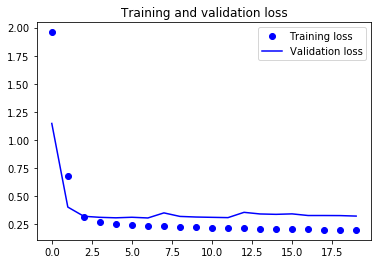

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [1]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [6]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

NameError: name 'Sequential' is not defined

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()